In [137]:
pip install pmdarima

     |████████████████████████████████| 656 kB 3.3 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [339]:
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import datetime
import requests
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm

warnings.filterwarnings('ignore')

# Load Data

In [283]:
east = pd.read_csv('data/east_daily.csv')
midwest = pd.read_csv('data/midwest_daily.csv') 
south = pd.read_csv('data/south_daily.csv') 
west = pd.read_csv('data/west_daily.csv') 

# Check Stationarity

In [284]:
X = east.daily_deaths
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.842138
p-value: 0.002504
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


In [285]:
X = midwest.daily_deaths
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.473716
p-value: 0.122001
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


In [286]:
X = south.daily_deaths
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.104854
p-value: 0.026196
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


In [287]:
X = west.daily_deaths
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.816341
p-value: 0.055977
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


# Differencing

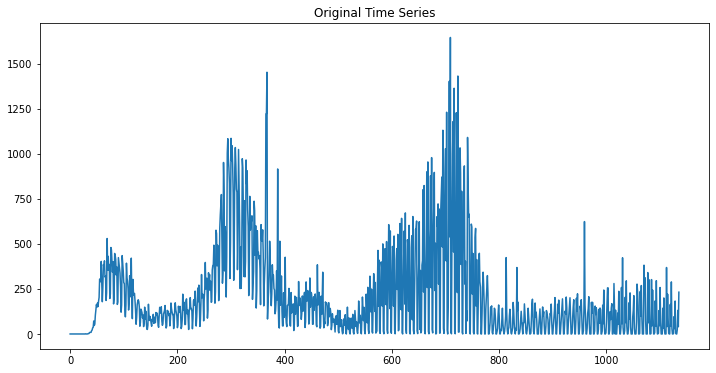

In [288]:
plt.figure(figsize=(12, 6))
plt.plot(midwest['daily_deaths'], label='Original Time Series')
plt.title('Original Time Series')
plt.show()

In [290]:
midwest_stationary = midwest['date'].to_frame().join(midwest['daily_deaths'].diff(1).fillna(0))

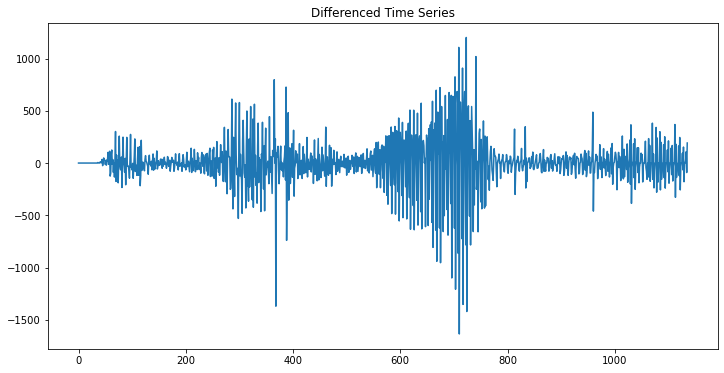

In [291]:
plt.figure(figsize=(12, 6))
plt.plot(midwest_stationary['daily_deaths'], label='Differenced Time Series')
plt.title('Differenced Time Series')
plt.show()

In [292]:
south_stationary = south['date'].to_frame().join(south['daily_deaths'].diff(1).fillna(0))

In [293]:
west_stationary = west['date'].to_frame().join(west['daily_deaths'].diff(1).fillna(0))

# Check Stationarity After Differencing

In [294]:
X = midwest_stationary.daily_deaths
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.612100
p-value: 0.000000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


In [295]:
X = south_stationary.daily_deaths
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.157430
p-value: 0.000000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


In [296]:
X = west_stationary.daily_deaths
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.691688
p-value: 0.000001
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


# Create New CSVs

In [297]:
midwest_stationary.to_csv('midwest_stationary.csv', index = False)

In [298]:
south_stationary.to_csv('south_stationary.csv', index = False)

In [299]:
west_stationary.to_csv('west_stationary.csv', index = False)

# Split Data Into Train and Test

In [315]:
east_stationary = pd.read_csv('data/east_daily.csv', index_col=0, parse_dates=[0])
midwest_stationary = pd.read_csv('data/midwest_stationary.csv', index_col=0, parse_dates=[0])
south_stationary = pd.read_csv('data/south_stationary.csv', index_col=0, parse_dates=[0])
west_stationary = pd.read_csv('data/west_stationary.csv', index_col=0, parse_dates=[0])

In [316]:
east_stationary = east_stationary.sort_index()
midwest_stationary = midwest_stationary.sort_index()
south_stationary = south_stationary.sort_index()
west_stationary = west_stationary.sort_index()

In [317]:
train_size = int(len(east_stationary) * 0.9)

east_train, east_test = east_stationary[0:train_size], east_stationary[train_size:]
print(east_train.shape, east_test.shape)

midwest_train, midwest_test = midwest_stationary[0:train_size], midwest_stationary[train_size:]
print(midwest_train.shape, midwest_test.shape)

south_train, south_test = south_stationary[0:train_size], south_stationary[train_size:]
print(south_train.shape, south_test.shape)

west_train, west_test = west_stationary[0:train_size], west_stationary[train_size:]
print(west_train.shape, west_test.shape)

(1022, 1) (114, 1)
(1022, 1) (114, 1)
(1022, 1) (114, 1)
(1022, 1) (114, 1)


In [318]:
east_test \
    .rename(columns={'daily_deaths': 'TEST SET'}) \
    .join(east_train.rename(columns={'daily_deaths': 'TRAINING SET'}), how='outer')

midwest_test \
    .rename(columns={'daily_deaths': 'TEST SET'}) \
    .join(midwest_train.rename(columns={'daily_deaths': 'TRAINING SET'}), how='outer')

south_test \
    .rename(columns={'daily_deaths': 'TEST SET'}) \
    .join(south_train.rename(columns={'daily_deaths': 'TRAINING SET'}), how='outer')

west_test \
    .rename(columns={'daily_deaths': 'TEST SET'}) \
    .join(west_train.rename(columns={'daily_deaths': 'TRAINING SET'}), how='outer')

,TEST SET,TRAINING SET
date,,
2020-02-12,NaN,0.0
2020-02-13,NaN,0.0
2020-02-14,NaN,0.0
2020-02-15,NaN,0.0
2020-02-16,NaN,0.0
...,...,...
2023-03-19,0.0,NaN
2023-03-20,37.0,NaN
2023-03-21,-4.0,NaN


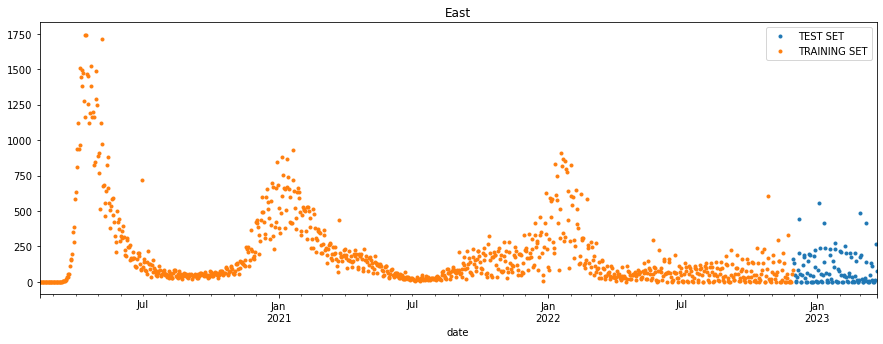

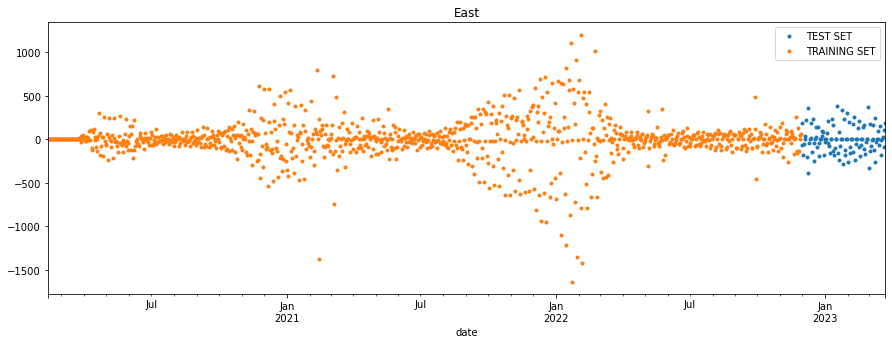

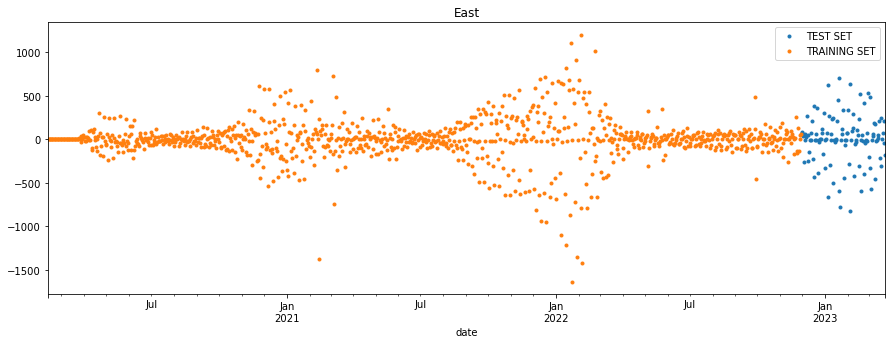

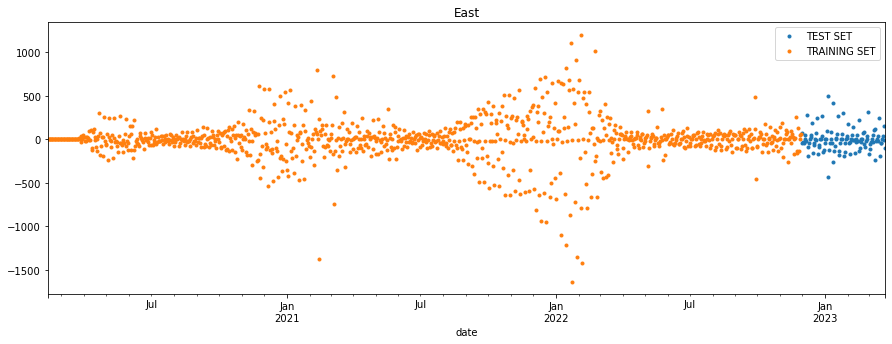

In [319]:
_ = east_test \
    .rename(columns={'daily_deaths': 'TEST SET'}) \
    .join(east_train.rename(columns={'daily_deaths': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='East', style='.')

_ = midwest_test \
    .rename(columns={'daily_deaths': 'TEST SET'}) \
    .join(midwest_train.rename(columns={'daily_deaths': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='East', style='.')

_ = south_test \
    .rename(columns={'daily_deaths': 'TEST SET'}) \
    .join(midwest_train.rename(columns={'daily_deaths': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='East', style='.')

_ = west_test \
    .rename(columns={'daily_deaths': 'TEST SET'}) \
    .join(midwest_train.rename(columns={'daily_deaths': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='East', style='.')

# ACF and PACF

### east

AR(1) model
- ACF tails off
- PACF cut off at lag 1

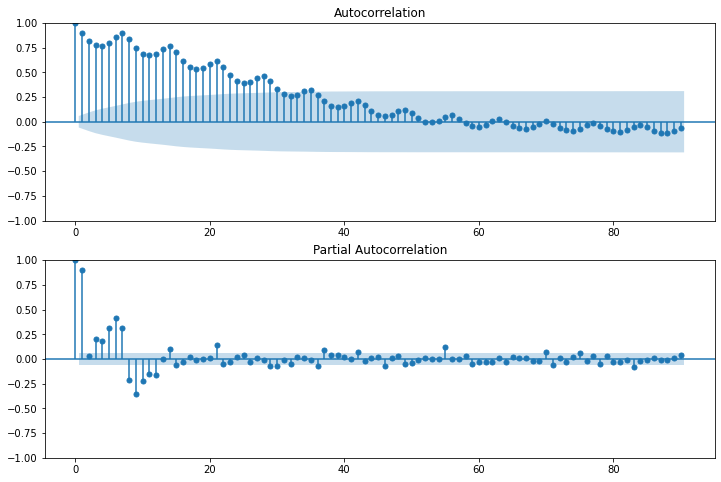

In [328]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(east_stationary,lags=90,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(east_stationary,lags=90,ax=ax2)

### midwest

MA(1) model
- ACF cut off at lag 1
- PACF tails off

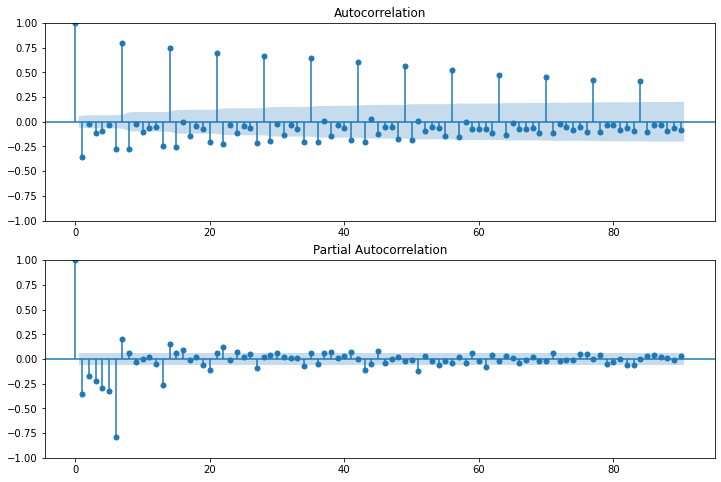

In [329]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(midwest_stationary,lags=90,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(midwest_stationary,lags=90,ax=ax2)

### south

MA(5) model
- ACF cut off at lag 5
- PACF tails off

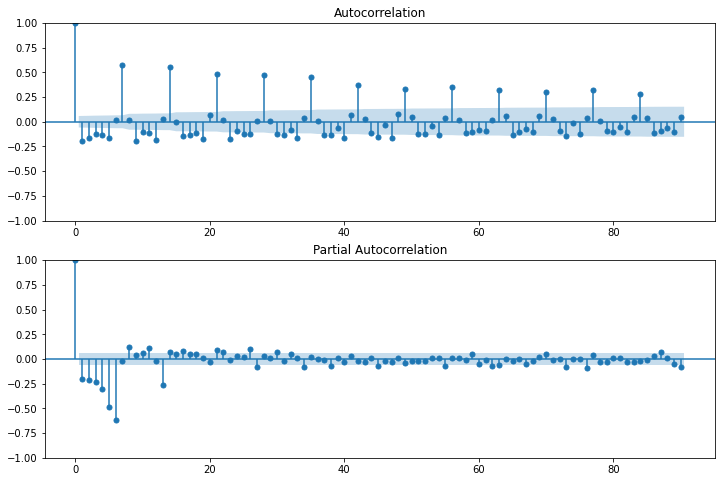

In [330]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(south_stationary,lags=90,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(south_stationary,lags=90,ax=ax2)

### west

MA(5) model
- ACF cut off at lag 5
- PACF tails off

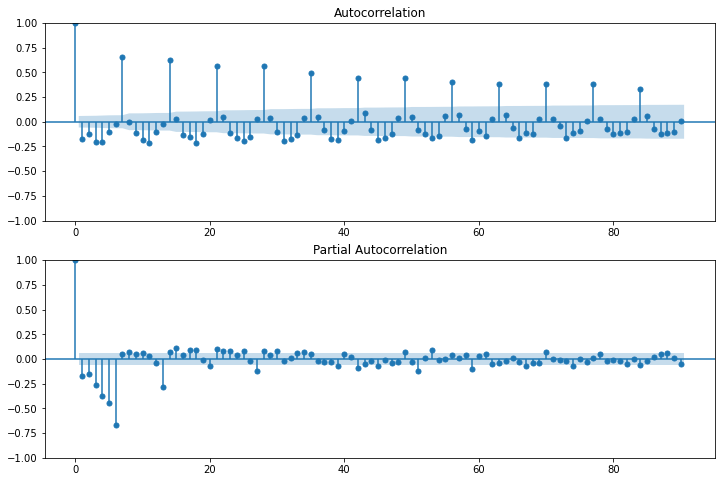

In [331]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(west_stationary,lags=90,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(west_stationary,lags=90,ax=ax2)

# ARIMA Models (grid search p and q)

In [361]:
def MASE(Actual, Predicted):
    n = len(Actual)
    
    mae = mean_absolute_error(Actual, Predicted)

    # Calculate the denominator
    denominator = 1 / (n - 1) * np.sum(np.abs(Predicted.iloc[1:].values - Actual.iloc[:-1].values))

    # Avoid division by zero or small denominators
    if denominator > 1e-6:
        mase = mae / denominator
    else:
        mase = np.inf

    return mase

# Grid Search p and q

### east

In [373]:
results=[]
for p in range(0,5):
    for q in range(0,5):
        model=sm.tsa.arima.ARIMA(east_train['daily_deaths'],order=(p,0,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

,p,q,aic
24,4,4,12019.444256
18,3,3,12027.195774
19,3,4,12029.635327
22,4,2,12073.746497
23,4,3,12083.189447
14,2,4,12209.989462
13,2,3,12260.905697
9,1,4,12307.445470
21,4,1,12328.592672
16,3,1,12353.494338


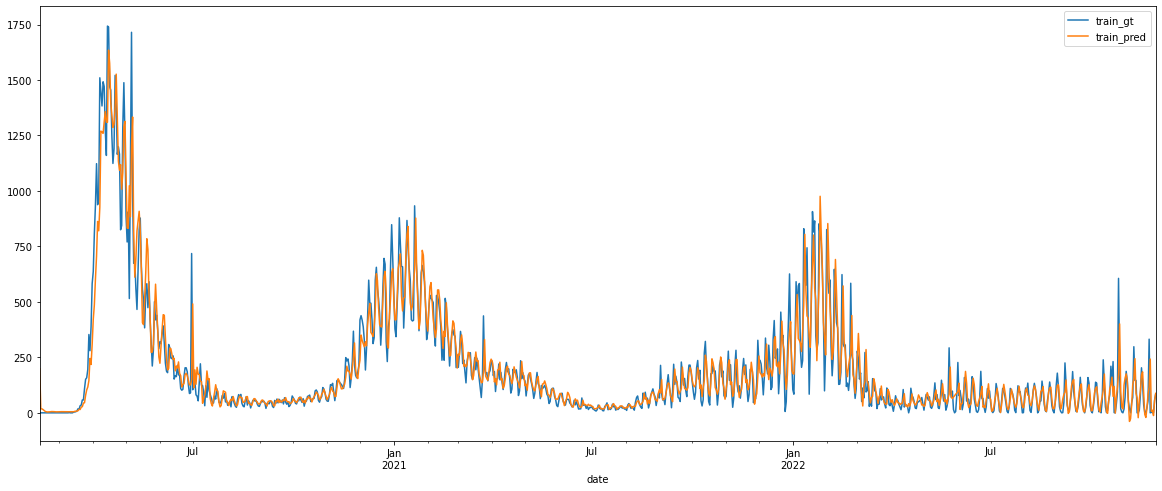

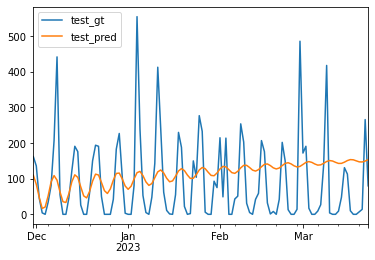

Training Set Metrics:
R-squared: 0.8979603749246248
MAE: 49.03799759212213
MASE: 0.00020735792498815907

Testing Set Metrics:
R-squared: -0.0006393340197585751
MAE: 91.53067439385967
MASE: 0.008151072042021423


In [374]:
model = sm.tsa.arima.ARIMA(east_train['daily_deaths'],order=(4,0,4))
model = model.fit()

train_pred=model.fittedvalues
pd.concat([east_train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])
plt.show()

east_test.index = pd.to_datetime(east_test.index)

test_pred=model.predict(start=len(east_train), end=len(east_train)+len(east_test)-1, dynamic=True)
pd.concat([east_test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])
plt.show()

# Calculate R-squared, MAE for the training set
r2_train = r2_score(east_train, train_pred)
mae_train = mean_absolute_error(east_train, train_pred)
mase_train = MASE(east_train, train_pred)

print("Training Set Metrics:")
print("R-squared:", r2_train)
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate RMSE, R-squared, and MAE for the testing set
r2_test = r2_score(east_test, test_pred)
mae_test = mean_absolute_error(east_test, test_pred)
mase_test = MASE(east_test, test_pred)

print("\nTesting Set Metrics:")
print("R-squared:", r2_test)
print("MAE:", mae_test)
print("MASE:", mase_test)

- seemed to underfit
- increase p and q
- shift down by 100
- filter above zero

In [467]:
results=[]
for p in range(3,7):
    for q in range(3,7):
        model=sm.tsa.arima.ARIMA(east_train['daily_deaths'],order=(p,0,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

,p,q,aic
15,6,6,11800.445572
11,5,6,11850.802397
14,6,5,11880.336364
10,5,5,11891.908581
6,4,5,11901.431019
2,3,5,11902.678270
9,5,4,11903.549108
3,3,6,11903.933034
7,4,6,11905.450196
13,6,4,11960.565424


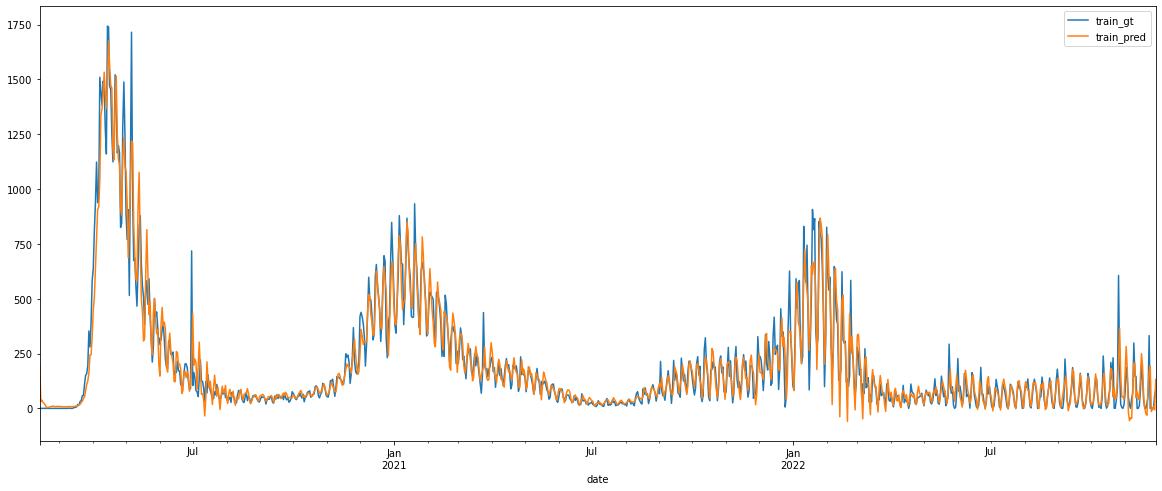

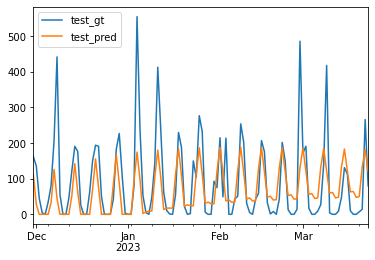

Training Set Metrics:
R-squared: 0.9189785707861602
MAE: 45.673374034029656
MASE: 0.00019174643015355323

Testing Set Metrics:
R-squared: 0.3574782514182264
MAE: 59.725889249924826
MASE: 0.005597274975354982


In [405]:
model = sm.tsa.arima.ARIMA(east_train['daily_deaths'],order=(6,0,6))
model = model.fit()

train_pred=model.fittedvalues
pd.concat([east_train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])
plt.show()

east_test.index = pd.to_datetime(east_test.index)

test_pred=model.predict(start=len(east_train), end=len(east_train)+len(east_test)-1, dynamic=True)
test_pred = test_pred - 100
test_pred[test_pred<0] = 0
pd.concat([east_test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])
plt.show()

# Calculate R-squared, MAE for the training set
r2_train = r2_score(east_train, train_pred)
mae_train = mean_absolute_error(east_train, train_pred)
mase_train = MASE(east_train, train_pred)

print("Training Set Metrics:")
print("R-squared:", r2_train)
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate RMSE, R-squared, and MAE for the testing set
r2_test = r2_score(east_test, test_pred)
mae_test = mean_absolute_error(east_test, test_pred)
mase_test = MASE(east_test, test_pred)

print("\nTesting Set Metrics:")
print("R-squared:", r2_test)
print("MAE:", mae_test)
print("MASE:", mase_test)

### midwest

In [376]:
results=[]
for p in range(0,5):
    for q in range(0,5):
        model=sm.tsa.arima.ARIMA(midwest_train['daily_deaths'],order=(p,1,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

,p,q,aic
24,4,4,13444.919632
9,1,4,13562.858191
23,4,3,13590.059980
8,1,3,13616.737234
3,0,3,13628.156250
7,1,2,13631.972753
4,0,4,13645.302660
2,0,2,13670.510536
14,2,4,13705.708548
18,3,3,13727.669349


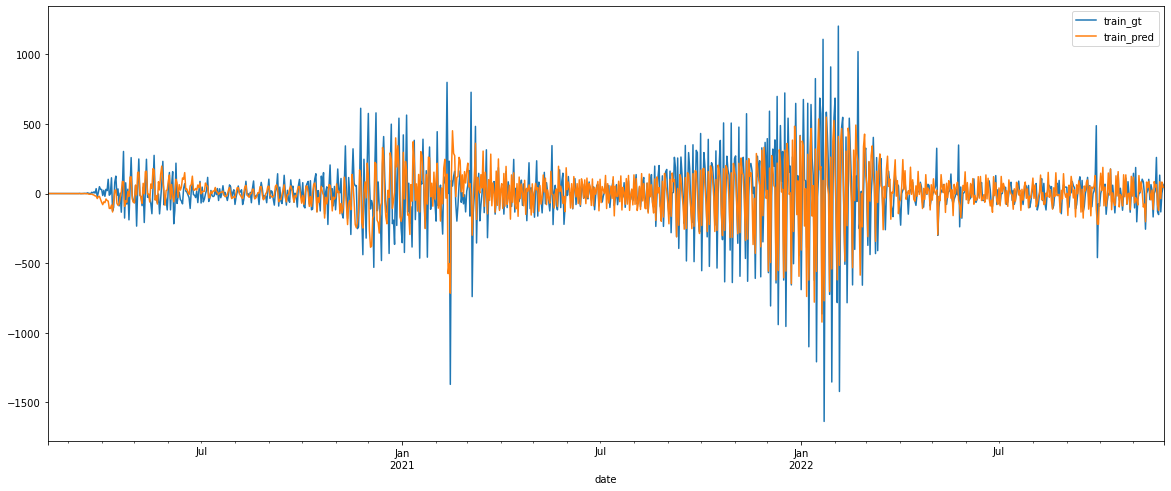

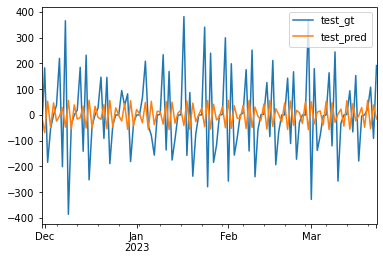

Training Set Metrics:
R-squared: 0.485058270958012
MAE: 114.240633670136
MASE: 0.0005720445762899049

Testing Set Metrics:
R-squared: -0.4084281494757429
MAE: 142.8242330283231
MASE: 0.010121434312876841


In [377]:
model = sm.tsa.arima.ARIMA(midwest_train['daily_deaths'],order=(4,1,4))
model = model.fit()

train_pred=model.fittedvalues
pd.concat([midwest_train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])
plt.show()

midwest_test.index = pd.to_datetime(midwest_test.index)

test_pred=model.predict(start=len(midwest_train), end=len(midwest_train)+len(midwest_test)-1, dynamic=True)
pd.concat([midwest_test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])
plt.show()

# Calculate R-squared, MAE for the training set
r2_train = r2_score(midwest_train, train_pred)
mae_train = mean_absolute_error(midwest_train, train_pred)
mase_train = MASE(midwest_train, train_pred)

print("Training Set Metrics:")
print("R-squared:", r2_train)
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate RMSE, R-squared, and MAE for the testing set
r2_test = r2_score(midwest_test, test_pred)
mae_test = mean_absolute_error(midwest_test, test_pred)
mase_test = MASE(midwest_test, test_pred)

print("\nTesting Set Metrics:")
print("R-squared:", r2_test)
print("MAE:", mae_test)
print("MASE:", mase_test)

- increase p and q
- change negative death values to zero for both prediction and test

In [468]:
results=[]
for p in range(3,7):
    for q in range(3,7):
        model=sm.tsa.arima.ARIMA(midwest_train['daily_deaths'],order=(p,1,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

,p,q,aic
15,6,6,12658.953850
13,6,4,12661.417033
14,6,5,12661.846462
12,6,3,12667.055664
5,4,4,13444.919632
11,5,6,13577.446045
4,4,3,13590.059980
8,5,3,13590.352952
9,5,4,13616.865293
6,4,5,13645.384797


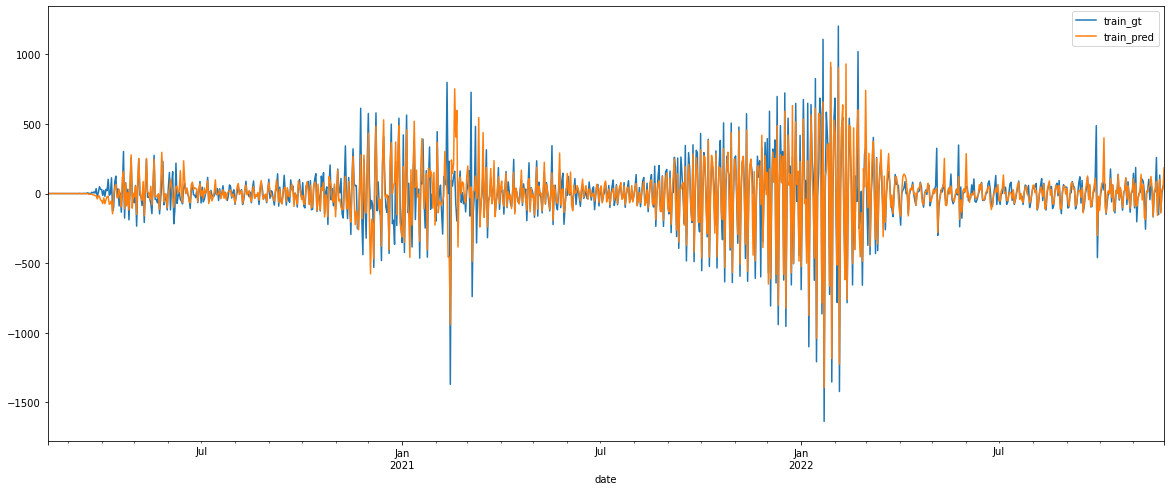

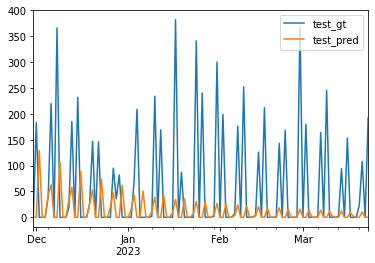

Training Set Metrics:
R-squared: 0.7612377969246924
MAE: 67.80854253435264
MASE: 0.00031748307264801843

Testing Set Metrics:
R-squared: -0.23165837124421218
MAE: 60.0298786400409
MASE: 0.008615278528946592


In [478]:
model = sm.tsa.arima.ARIMA(midwest_train['daily_deaths'],order=(6,1,6))
model = model.fit()

train_pred=model.fittedvalues
pd.concat([midwest_train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])
plt.show()

midwest_test.index = pd.to_datetime(midwest_test.index)

test_pred=model.predict(start=len(midwest_train), end=len(midwest_train)+len(midwest_test)-1, dynamic=True)
test_pred[test_pred<0] = 0
midwest_test[midwest_test<0]=0
pd.concat([midwest_test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])
plt.show()

# Calculate R-squared, MAE for the training set
r2_train = r2_score(midwest_train, train_pred)
mae_train = mean_absolute_error(midwest_train, train_pred)
mase_train = MASE(midwest_train, train_pred)

print("Training Set Metrics:")
print("R-squared:", r2_train)
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate RMSE, R-squared, and MAE for the testing set
r2_test = r2_score(midwest_test, test_pred)
mae_test = mean_absolute_error(midwest_test, test_pred)
mase_test = MASE(midwest_test, test_pred)

print("\nTesting Set Metrics:")
print("R-squared:", r2_test)
print("MAE:", mae_test)
print("MASE:", mase_test)

### south

In [378]:
results=[]
for p in range(0,5):
    for q in range(0,5):
        model=sm.tsa.arima.ARIMA(south_train['daily_deaths'],order=(p,1,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

,p,q,aic
12,2,2,10.000000
22,4,2,14198.107887
14,2,4,14389.296340
3,0,3,14395.212203
8,1,3,14396.996320
9,1,4,14397.742557
4,0,4,14419.797985
2,0,2,14534.584142
21,4,1,14534.652438
18,3,3,14576.988985


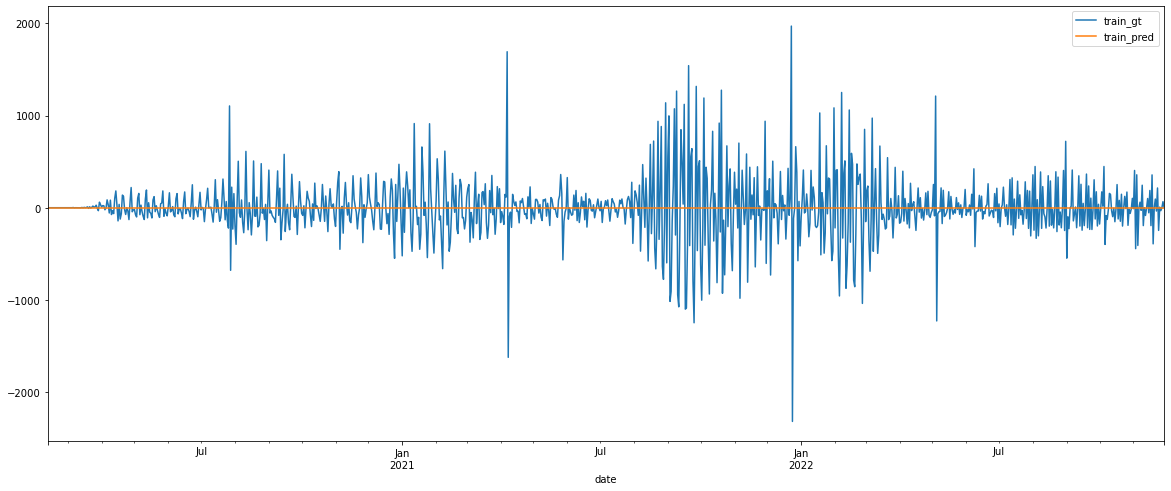

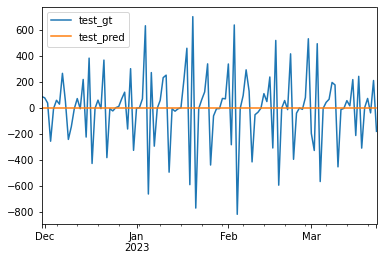

Training Set Metrics:
R-squared: -3.9126975215353355e-08
MAE: 204.48825831702544
MASE: 0.0009784782632187106

Testing Set Metrics:
R-squared: -7.987745886950393e-08
MAE: 192.359649122807
MASE: 0.008845341845900906


In [381]:
model = sm.tsa.arima.ARIMA(south_train['daily_deaths'],order=(2,1,2))
model = model.fit()

train_pred=model.fittedvalues
pd.concat([south_train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])
plt.show()

south_test.index = pd.to_datetime(south_test.index)

test_pred=model.predict(start=len(south_train), end=len(south_train)+len(south_test)-1, dynamic=True)
pd.concat([south_test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])
plt.show()

# Calculate R-squared, MAE for the training set
r2_train = r2_score(south_train, train_pred)
mae_train = mean_absolute_error(south_train, train_pred)
mase_train = MASE(south_train, train_pred)

print("Training Set Metrics:")
print("R-squared:", r2_train)
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate RMSE, R-squared, and MAE for the testing set
r2_test = r2_score(south_test, test_pred)
mae_test = mean_absolute_error(south_test, test_pred)
mase_test = MASE(south_test, test_pred)

print("\nTesting Set Metrics:")
print("R-squared:", r2_test)
print("MAE:", mae_test)
print("MASE:", mase_test)

- increase p and q
- filter above zero
- scale test pred by 1.6

In [479]:
results=[]
for p in range(3,7):
    for q in range(3,7):
        model=sm.tsa.arima.ARIMA(south_train['daily_deaths'],order=(p,1,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

,p,q,aic
15,6,6,13720.187492
14,6,5,13728.601556
12,6,3,13753.752125
13,6,4,13756.371780
11,5,6,13964.215320
9,5,4,14017.346941
8,5,3,14025.716818
10,5,5,14053.462632
7,4,6,14197.016136
3,3,6,14332.068806


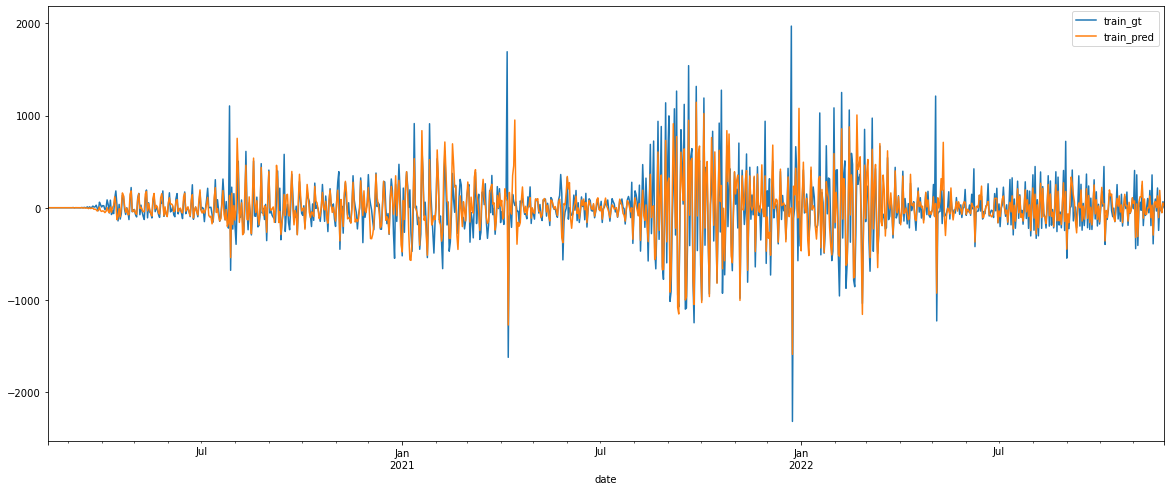

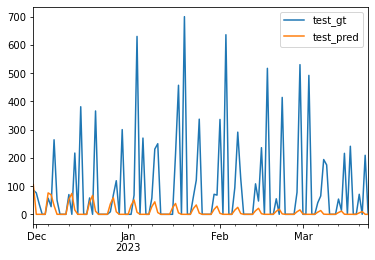

Training Set Metrics:
R-squared: 0.6506617364130307
MAE: 115.10464571379147
MASE: 0.00038322581271183756

Testing Set Metrics:
R-squared: -0.31177252507569353
MAE: 91.63855735343893
MASE: 0.008289090749491973


In [488]:
model = sm.tsa.arima.ARIMA(south_train['daily_deaths'],order=(6,1,6))
model = model.fit()

train_pred=model.fittedvalues
pd.concat([south_train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])
plt.show()

south_test.index = pd.to_datetime(south_test.index)

test_pred=model.predict(start=len(south_train), end=len(south_train)+len(south_test)-1, dynamic=True)
test_pred[test_pred<0] = 0
south_test[south_test<0]=0
test_pred = test_pred * 2


pd.concat([south_test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])
plt.show()

# Calculate R-squared, MAE for the training set
r2_train = r2_score(south_train, train_pred)
mae_train = mean_absolute_error(south_train, train_pred)
mase_train = MASE(south_train, train_pred)

print("Training Set Metrics:")
print("R-squared:", r2_train)
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate RMSE, R-squared, and MAE for the testing set
r2_test = r2_score(south_test, test_pred)
mae_test = mean_absolute_error(south_test, test_pred)
mase_test = MASE(south_test, test_pred)

print("\nTesting Set Metrics:")
print("R-squared:", r2_test)
print("MAE:", mae_test)
print("MASE:", mase_test)

### west

In [382]:
results=[]
for p in range(0,5):
    for q in range(0,5):
        model=sm.tsa.arima.ARIMA(west_train['daily_deaths'],order=(p,1,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

,p,q,aic
24,4,4,12644.844427
14,2,4,12861.385542
9,1,4,12881.782656
8,1,3,12882.727930
4,0,4,12906.747923
3,0,3,12915.796785
21,4,1,12962.063667
2,0,2,13028.184706
22,4,2,13029.148524
23,4,3,13042.046987


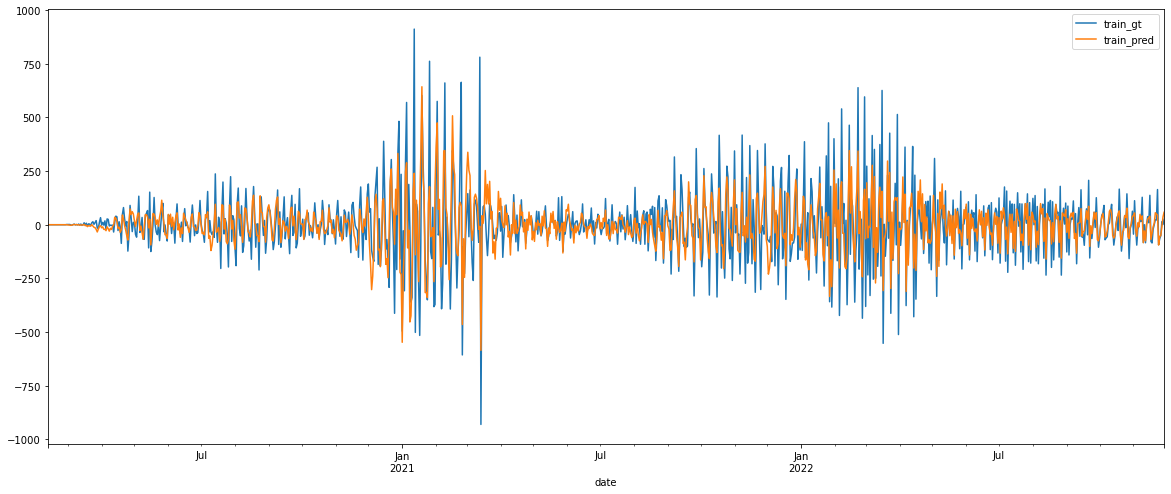

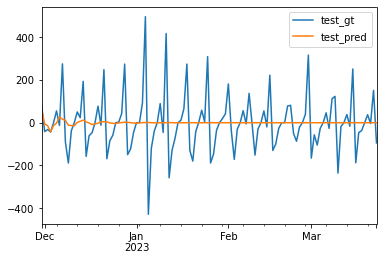

Training Set Metrics:
R-squared: 0.4658337007414375
MAE: 75.93792758927509
MASE: 0.0005540926890058662

Testing Set Metrics:
R-squared: 0.012333476629186713
MAE: 88.43317281063261
MASE: 0.00872626729229028


In [383]:
model = sm.tsa.arima.ARIMA(west_train['daily_deaths'],order=(4,1,4))
model = model.fit()

train_pred=model.fittedvalues
pd.concat([west_train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])
plt.show()

west_test.index = pd.to_datetime(west_test.index)

test_pred=model.predict(start=len(west_train), end=len(west_train)+len(west_test)-1, dynamic=True)
pd.concat([west_test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])
plt.show()

# Calculate R-squared, MAE for the training set
r2_train = r2_score(west_train, train_pred)
mae_train = mean_absolute_error(west_train, train_pred)
mase_train = MASE(west_train, train_pred)

print("Training Set Metrics:")
print("R-squared:", r2_train)
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate RMSE, R-squared, and MAE for the testing set
r2_test = r2_score(west_test, test_pred)
mae_test = mean_absolute_error(west_test, test_pred)
mase_test = MASE(west_test, test_pred)

print("\nTesting Set Metrics:")
print("R-squared:", r2_test)
print("MAE:", mae_test)
print("MASE:", mase_test)

- increase p and q
- filter above zero
- scale test pred

In [459]:
results=[]
for p in range(3,7):
    for q in range(3,7):
        model=sm.tsa.arima.ARIMA(west_train['daily_deaths'],order=(p,1,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

,p,q,aic
15,6,6,12176.035999
14,6,5,12183.379511
12,6,3,12187.176396
13,6,4,12191.802854
9,5,4,12531.101317
8,5,3,12634.332203
11,5,6,12644.221655
5,4,4,12644.844427
7,4,6,12694.375760
10,5,5,12714.373313


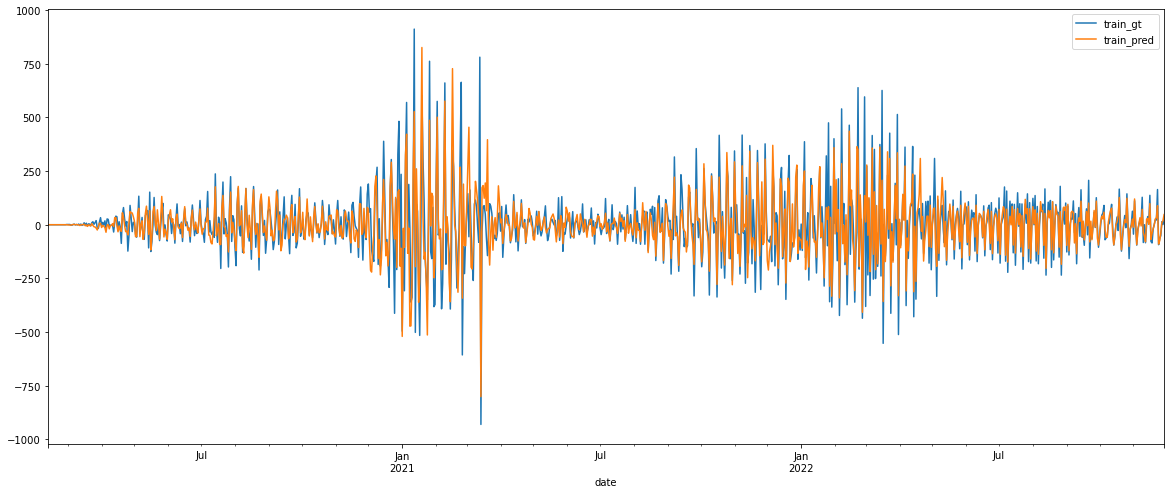

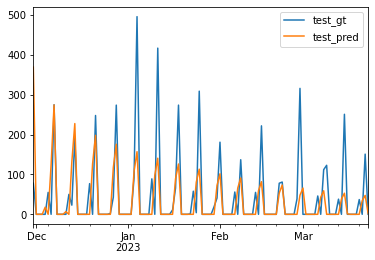

Training Set Metrics:
R-squared: 0.6601899900950967
MAE: 54.80193598206107
MASE: 0.00037632792164732744

Testing Set Metrics:
R-squared: 0.36032483707698715
MAE: 36.16527313702939
MASE: 0.005228979252710879


In [466]:
model = sm.tsa.arima.ARIMA(west_train['daily_deaths'],order=(6,1,6))
model = model.fit()

train_pred=model.fittedvalues
pd.concat([west_train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])
plt.show()

west_test.index = pd.to_datetime(west_test.index)

test_pred=model.predict(start=len(west_train), end=len(west_train)+len(west_test)-1, dynamic=True)
test_pred[test_pred<0] = 0
west_test[west_test<0]=0
test_pred = test_pred * 3
pd.concat([west_test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])
plt.show()

# Calculate R-squared, MAE for the training set
r2_train = r2_score(west_train, train_pred)
mae_train = mean_absolute_error(west_train, train_pred)
mase_train = MASE(west_train, train_pred)

print("Training Set Metrics:")
print("R-squared:", r2_train)
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate RMSE, R-squared, and MAE for the testing set
r2_test = r2_score(west_test, test_pred)
mae_test = mean_absolute_error(west_test, test_pred)
mase_test = MASE(west_test, test_pred)

print("\nTesting Set Metrics:")
print("R-squared:", r2_test)
print("MAE:", mae_test)
print("MASE:", mase_test)

# Time Series Decomposition

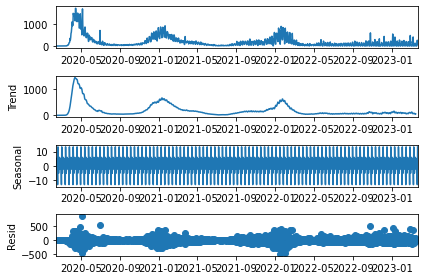

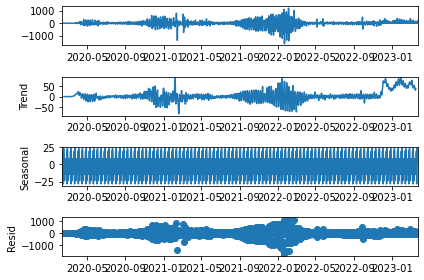

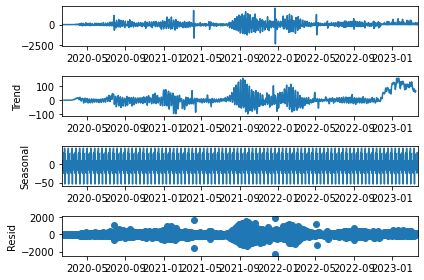

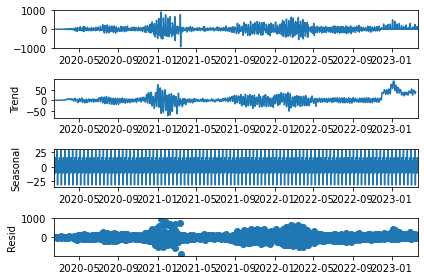

In [491]:
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal_decompose(east_stationary, period=12).plot()
plt.show()

seasonal_decompose(midwest_stationary, period=12).plot()
plt.show()

seasonal_decompose(south_stationary, period=12).plot()
plt.show()

seasonal_decompose(west_stationary, period=12).plot()
plt.show()

# SARIMA

### east

In [493]:
import warnings
import statsmodels.api 
warnings.filterwarnings("ignore",category = statsmodels.tools.sm_exceptions.ConvergenceWarning)
warnings.filterwarnings("ignore",category =  UserWarning)
warnings.filterwarnings("ignore",category = statsmodels.tools.sm_exceptions.ValueWarning)

if 1:
    import statsmodels.api as sm

    results=[]
    for p in range(1,3):
        for q in range(1,3):
            for P in range(1,3):
                for Q in range(1,3):
                    print(p,q,P,Q)
                    model=sm.tsa.statespace.SARIMAX(east_train,order=(p,0,q), seasonal_order=(P,0,Q,12)).fit()
                    results.append([p,q,P,Q,model.aic])

1 1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.37700D+00    |proj g|=  5.68911D-01

At iterate    5    f=  6.11792D+00    |proj g|=  1.05995D-02


 This problem is unconstrained.



At iterate   10    f=  6.10029D+00    |proj g|=  7.08456D-03

At iterate   15    f=  6.09947D+00    |proj g|=  4.24803D-03

At iterate   20    f=  6.09923D+00    |proj g|=  1.36731D-03

At iterate   25    f=  6.09868D+00    |proj g|=  4.71995D-03

At iterate   30    f=  6.09829D+00    |proj g|=  4.67682D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     36      1     0     0   4.947D-05   6.098D+00
  F =   6.0982934322631435     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 1 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =     

 This problem is unconstrained.



At iterate    5    f=  6.10738D+00    |proj g|=  1.28182D-02

At iterate   10    f=  6.09655D+00    |proj g|=  7.63254D-02

At iterate   15    f=  6.08142D+00    |proj g|=  1.20575D-02

At iterate   20    f=  6.08102D+00    |proj g|=  1.26267D-02

At iterate   25    f=  6.07999D+00    |proj g|=  7.53625D-04

At iterate   30    f=  6.07976D+00    |proj g|=  4.67736D-03

At iterate   35    f=  6.07814D+00    |proj g|=  5.21546D-03

At iterate   40    f=  6.07812D+00    |proj g|=  5.63377D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     41     52      1     0     0   9.285D-06   6.078D+00
  F =   6.07812335404

 This problem is unconstrained.



At iterate    5    f=  6.11657D+00    |proj g|=  1.04143D-02

At iterate   10    f=  6.08042D+00    |proj g|=  1.33656D-01

At iterate   15    f=  6.06712D+00    |proj g|=  3.11404D-03

At iterate   20    f=  6.06521D+00    |proj g|=  1.98821D-02

At iterate   25    f=  6.06259D+00    |proj g|=  1.96493D-03

At iterate   30    f=  6.06248D+00    |proj g|=  6.30393D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     44      1     0     0   1.911D-05   6.062D+00
  F =   6.0624562321494420     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 1 2 2
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f=  6.11852D+00    |proj g|=  3.01038D-02

At iterate   10    f=  6.10174D+00    |proj g|=  1.78488D-02

At iterate   15    f=  6.09916D+00    |proj g|=  2.68312D-02

At iterate   20    f=  6.06138D+00    |proj g|=  9.54803D-02

At iterate   25    f=  6.05257D+00    |proj g|=  1.01034D-02

At iterate   30    f=  6.04373D+00    |proj g|=  1.02814D-01

At iterate   35    f=  6.04018D+00    |proj g|=  2.16391D-01

At iterate   40    f=  6.03348D+00    |proj g|=  9.13129D-01

At iterate   45    f=  6.02721D+00    |proj g|=  1.71982D+00

At iterate   50    f=  6.02628D+00    |proj g|=  1.17677D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.03835D+00    |proj g|=  3.13706D-03

At iterate   10    f=  6.03671D+00    |proj g|=  2.19605D-02

At iterate   15    f=  6.03630D+00    |proj g|=  6.41067D-04

At iterate   20    f=  6.03589D+00    |proj g|=  1.54653D-03

At iterate   25    f=  6.03588D+00    |proj g|=  5.49341D-04

At iterate   30    f=  6.03582D+00    |proj g|=  1.26680D-03

At iterate   35    f=  6.03582D+00    |proj g|=  2.08712D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     35     38      1     0     0   2.087D-05   6.036D+00
  F =   6.0358165672879887     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  6.03745D+00    |proj g|=  4.80376D-03

At iterate   10    f=  6.03289D+00    |proj g|=  6.06335D-02

At iterate   15    f=  6.02616D+00    |proj g|=  1.91102D-03

At iterate   20    f=  6.02610D+00    |proj g|=  5.05886D-03

At iterate   25    f=  6.02530D+00    |proj g|=  7.20245D-03

At iterate   30    f=  6.02522D+00    |proj g|=  1.04170D-04

At iterate   35    f=  6.02522D+00    |proj g|=  5.06222D-04

At iterate   40    f=  6.02515D+00    |proj g|=  3.41017D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     44     50      1     0     0   4.951D-05   6.025D+00
  F =   6.02513497075

 This problem is unconstrained.



At iterate    5    f=  6.03863D+00    |proj g|=  1.36969D-02

At iterate   10    f=  6.02550D+00    |proj g|=  7.76492D-02

At iterate   15    f=  6.02252D+00    |proj g|=  1.31883D-02

At iterate   20    f=  6.02221D+00    |proj g|=  9.62122D-04

At iterate   25    f=  6.02203D+00    |proj g|=  1.09273D-02

At iterate   30    f=  6.02097D+00    |proj g|=  2.00719D-03

At iterate   35    f=  6.02096D+00    |proj g|=  1.96969D-03

At iterate   40    f=  6.02085D+00    |proj g|=  2.26348D-03

At iterate   45    f=  6.02084D+00    |proj g|=  1.43848D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     45     59   

 This problem is unconstrained.



At iterate    5    f=  6.03771D+00    |proj g|=  8.80864D-03

At iterate   10    f=  6.03273D+00    |proj g|=  1.97328D-02

At iterate   15    f=  6.02326D+00    |proj g|=  7.86015D-02

At iterate   20    f=  6.01076D+00    |proj g|=  1.17742D-02

At iterate   25    f=  5.99894D+00    |proj g|=  3.64081D-01

At iterate   30    f=  5.99441D+00    |proj g|=  3.12418D-02

At iterate   35    f=  5.98958D+00    |proj g|=  1.62916D-01

At iterate   40    f=  5.98587D+00    |proj g|=  2.38804D-01

At iterate   45    f=  5.98043D+00    |proj g|=  2.22838D+00

At iterate   50    f=  5.97990D+00    |proj g|=  1.89830D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  6.12138D+00    |proj g|=  8.20950D-03

At iterate   15    f=  6.11114D+00    |proj g|=  1.34863D-02

At iterate   20    f=  6.10835D+00    |proj g|=  6.58172D-03

At iterate   25    f=  6.10821D+00    |proj g|=  1.65795D-04

At iterate   30    f=  6.10820D+00    |proj g|=  5.95846D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     36      1     0     0   2.532D-05   6.108D+00
  F =   6.1081996922991832     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2 1 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =     

 This problem is unconstrained.



At iterate    5    f=  6.14127D+00    |proj g|=  1.02650D-01

At iterate   10    f=  6.11339D+00    |proj g|=  7.21567D-03

At iterate   15    f=  6.11303D+00    |proj g|=  1.16844D-03

At iterate   20    f=  6.10378D+00    |proj g|=  1.86128D-02

At iterate   25    f=  6.10231D+00    |proj g|=  2.37067D-04

At iterate   30    f=  6.10230D+00    |proj g|=  7.97480D-04

At iterate   35    f=  6.10225D+00    |proj g|=  3.07045D-04

At iterate   40    f=  6.10225D+00    |proj g|=  1.83871D-04

At iterate   45    f=  6.10225D+00    |proj g|=  3.99433D-04

At iterate   50    f=  6.10225D+00    |proj g|=  2.55810D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.15760D+00    |proj g|=  7.64426D-02

At iterate   10    f=  6.11794D+00    |proj g|=  1.77291D-02

At iterate   15    f=  6.11603D+00    |proj g|=  9.44097D-03

At iterate   20    f=  6.10121D+00    |proj g|=  1.75462D-02

At iterate   25    f=  6.09880D+00    |proj g|=  1.64788D-02

At iterate   30    f=  6.09868D+00    |proj g|=  1.62780D-04

At iterate   35    f=  6.09866D+00    |proj g|=  2.46157D-03

At iterate   40    f=  6.09860D+00    |proj g|=  2.54186D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     43     49      1     0     0   3.680D-05   6.099D+00
  F =   6.09859805144

 This problem is unconstrained.



At iterate    5    f=  6.14780D+00    |proj g|=  8.47443D-02

At iterate   10    f=  6.12271D+00    |proj g|=  3.89734D-02

At iterate   15    f=  6.10900D+00    |proj g|=  8.10691D-03

At iterate   20    f=  6.10720D+00    |proj g|=  1.29493D-02

At iterate   25    f=  6.10678D+00    |proj g|=  2.67931D-03

At iterate   30    f=  6.10238D+00    |proj g|=  7.32242D-02

At iterate   35    f=  6.09628D+00    |proj g|=  3.28906D-02

At iterate   40    f=  6.08282D+00    |proj g|=  6.55399D-02

At iterate   45    f=  6.07733D+00    |proj g|=  1.91468D-02

At iterate   50    f=  6.07133D+00    |proj g|=  9.18829D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.20389D+00    |proj g|=  1.53421D-01

At iterate   10    f=  6.10157D+00    |proj g|=  1.84238D-02

At iterate   15    f=  6.05955D+00    |proj g|=  9.49673D-02

At iterate   20    f=  6.04810D+00    |proj g|=  1.46444D-02

At iterate   25    f=  6.03771D+00    |proj g|=  1.59776D-02

At iterate   30    f=  6.03508D+00    |proj g|=  3.07871D-03

At iterate   35    f=  6.03491D+00    |proj g|=  5.75325D-03

At iterate   40    f=  6.03473D+00    |proj g|=  2.94805D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     43     52      1     0     0   6.858D-05   6.035D+00
  F =   6.03473162852

 This problem is unconstrained.



At iterate    5    f=  6.20080D+00    |proj g|=  1.74176D-01

At iterate   10    f=  6.09341D+00    |proj g|=  1.41422D-02

At iterate   15    f=  6.05913D+00    |proj g|=  1.26126D-01

At iterate   20    f=  6.04418D+00    |proj g|=  1.65399D-02

At iterate   25    f=  6.04288D+00    |proj g|=  3.06383D-03

At iterate   30    f=  6.04277D+00    |proj g|=  8.29744D-04

At iterate   35    f=  6.04092D+00    |proj g|=  3.04711D-02

At iterate   40    f=  6.02910D+00    |proj g|=  4.82950D-02

At iterate   45    f=  6.02647D+00    |proj g|=  6.82119D-03

At iterate   50    f=  6.02546D+00    |proj g|=  2.15518D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.21975D+00    |proj g|=  1.14231D-01

At iterate   10    f=  6.10395D+00    |proj g|=  1.75212D-02

At iterate   15    f=  6.06941D+00    |proj g|=  9.69728D-02

At iterate   20    f=  6.04512D+00    |proj g|=  1.28704D-02

At iterate   25    f=  6.03933D+00    |proj g|=  5.39920D-03

At iterate   30    f=  6.03366D+00    |proj g|=  7.46245D-02

At iterate   35    f=  6.02593D+00    |proj g|=  5.91808D-02

At iterate   40    f=  6.02396D+00    |proj g|=  1.84599D-03

At iterate   45    f=  6.02377D+00    |proj g|=  2.46975D-03

At iterate   50    f=  6.02235D+00    |proj g|=  3.43094D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.20648D+00    |proj g|=  1.63123D-01

At iterate   10    f=  6.11138D+00    |proj g|=  2.39033D-02

At iterate   15    f=  6.06242D+00    |proj g|=  5.74002D-02

At iterate   20    f=  6.04520D+00    |proj g|=  9.51415D-03

At iterate   25    f=  6.04089D+00    |proj g|=  5.29633D-03

At iterate   30    f=  6.03639D+00    |proj g|=  1.31500D-02

At iterate   35    f=  6.03480D+00    |proj g|=  1.49647D-03

At iterate   40    f=  6.03471D+00    |proj g|=  4.02442D-04

At iterate   45    f=  6.03471D+00    |proj g|=  1.09594D-04

At iterate   50    f=  6.03463D+00    |proj g|=  1.98091D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [494]:
# Create a DataFrame from the results
df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic')

df_results

,p,q,P,Q,aic
7,1,2,2,2,12238.910978
6,1,2,2,1,12320.597627
14,2,2,2,1,12325.679620
5,1,2,1,2,12329.375880
3,1,1,2,2,12331.715189
13,2,2,1,2,12332.049899
12,2,2,1,1,12348.991449
4,1,2,1,1,12349.209064
15,2,2,2,2,12352.775339
2,1,1,2,1,12403.660539


In [497]:
model=sm.tsa.statespace.SARIMAX(east_train,order=(1, 0, 2),seasonal_order=(2,0,2,12))
model=model.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.10564D+00    |proj g|=  1.78235D-01

At iterate    5    f=  6.03771D+00    |proj g|=  8.80864D-03

At iterate   10    f=  6.03273D+00    |proj g|=  1.97328D-02

At iterate   15    f=  6.02326D+00    |proj g|=  7.86015D-02

At iterate   20    f=  6.01076D+00    |proj g|=  1.17742D-02

At iterate   25    f=  5.99894D+00    |proj g|=  3.64081D-01

At iterate   30    f=  5.99441D+00    |proj g|=  3.12418D-02

At iterate   35    f=  5.98958D+00    |proj g|=  1.62916D-01

At iterate   40    f=  5.98587D+00    |proj g|=  2.38804D-01

At iterate   45    f=  5.98043D+00    |proj g|=  2.22838D+00

At iterate   50    f=  5.97990D+00    |proj g|=  1.89830D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

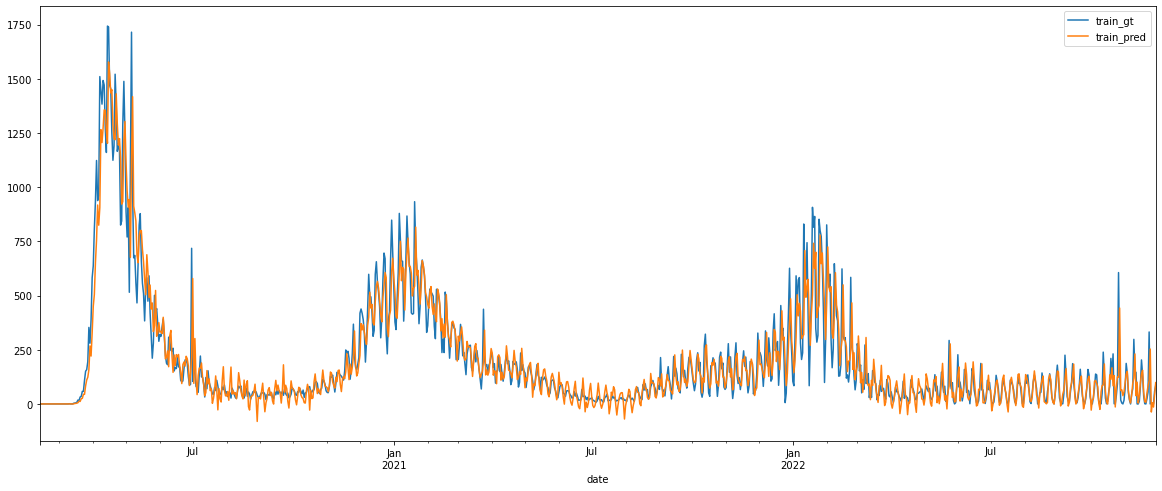

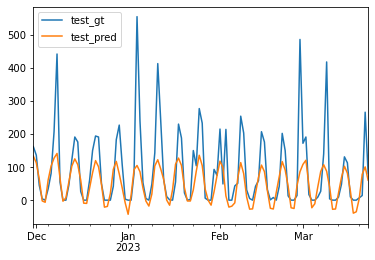

Training Set Metrics:
R-squared: 0.8707452003245586
MAE: 57.22304409019648
MASE: 0.00023820747870331718

Testing Set Metrics:
R-squared: 0.3090746083760957
MAE: 56.467224619028656
MASE: 0.005251906827650216


In [498]:
train_pred=model.fittedvalues
pd.concat([east_train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])
plt.show()

east_test.index = pd.to_datetime(east_test.index)

test_pred=model.predict(start=len(east_train), end=len(east_train)+len(east_test)-1, dynamic=True)
pd.concat([east_test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])
plt.show()

# Calculate R-squared, MAE for the training set
r2_train = r2_score(east_train, train_pred)
mae_train = mean_absolute_error(east_train, train_pred)
mase_train = MASE(east_train, train_pred)

print("Training Set Metrics:")
print("R-squared:", r2_train)
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate RMSE, R-squared, and MAE for the testing set
r2_test = r2_score(east_test, test_pred)
mae_test = mean_absolute_error(east_test, test_pred)
mase_test = MASE(east_test, test_pred)

print("\nTesting Set Metrics:")
print("R-squared:", r2_test)
print("MAE:", mae_test)
print("MASE:", mase_test)

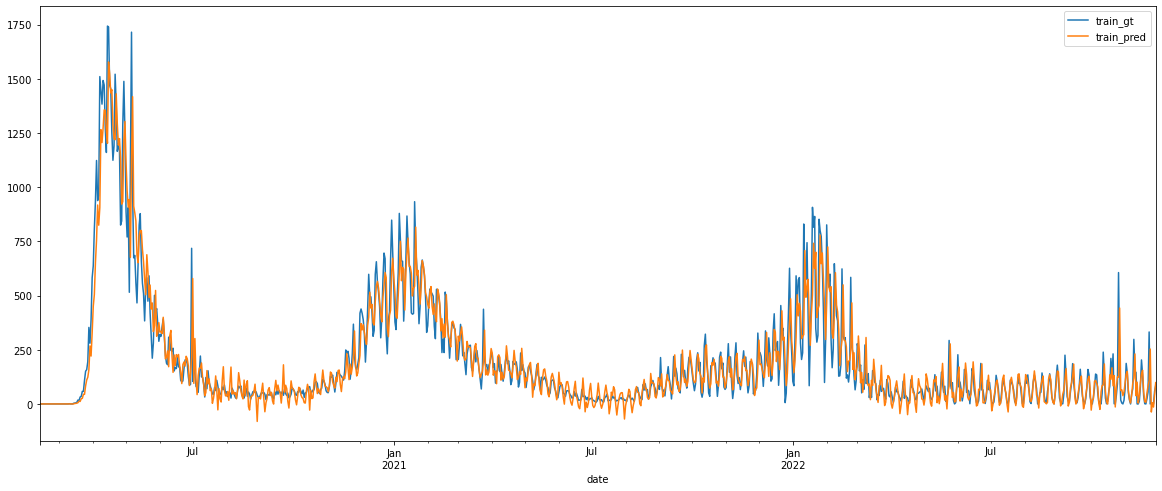

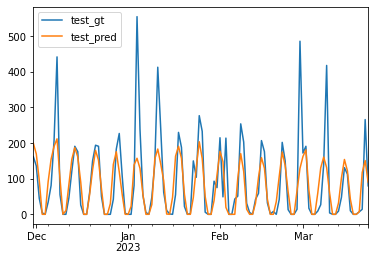

Training Set Metrics:
R-squared: 0.8707452003245586
MAE: 57.22304409019648
MASE: 0.00023820747870331718

Testing Set Metrics:
R-squared: 0.5101745272409257
MAE: 45.038262612373615
MASE: 0.004025366310075676


In [502]:
train_pred=model.fittedvalues
pd.concat([east_train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])
plt.show()

east_test.index = pd.to_datetime(east_test.index)

test_pred=model.predict(start=len(east_train), end=len(east_train)+len(east_test)-1, dynamic=True)
test_pred[test_pred<0] = 0
test_pred = test_pred * 1.5
pd.concat([east_test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])
plt.show()

# Calculate R-squared, MAE for the training set
r2_train = r2_score(east_train, train_pred)
mae_train = mean_absolute_error(east_train, train_pred)
mase_train = MASE(east_train, train_pred)

print("Training Set Metrics:")
print("R-squared:", r2_train)
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate RMSE, R-squared, and MAE for the testing set
r2_test = r2_score(east_test, test_pred)
mae_test = mean_absolute_error(east_test, test_pred)
mase_test = MASE(east_test, test_pred)

print("\nTesting Set Metrics:")
print("R-squared:", r2_test)
print("MAE:", mae_test)
print("MASE:", mase_test)

### midwest

In [511]:
if 1:
    import statsmodels.api as sm

    results=[]
    for p in range(1,3):
        for q in range(1,3):
            for P in range(1,3):
                for Q in range(1,3):
                    print(p,q,P,Q)
                    model=sm.tsa.statespace.SARIMAX(east_train,order=(p,1,q), seasonal_order=(P,1,Q,12)).fit()
                    results.append([p,q,P,Q,model.aic])

1 1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.31977D+00    |proj g|=  1.56700D-01


 This problem is unconstrained.



At iterate    5    f=  6.19528D+00    |proj g|=  5.87521D-03

At iterate   10    f=  6.17286D+00    |proj g|=  3.87691D-02

At iterate   15    f=  6.08187D+00    |proj g|=  6.26776D-02

At iterate   20    f=  6.07927D+00    |proj g|=  1.34758D-03

At iterate   25    f=  6.07912D+00    |proj g|=  1.16159D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     33      1     0     0   1.661D-05   6.079D+00
  F =   6.0791158718736815     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 1 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =     

 This problem is unconstrained.



At iterate    5    f=  6.19588D+00    |proj g|=  7.42306D-03

At iterate   10    f=  6.11563D+00    |proj g|=  3.01487D-01

At iterate   15    f=  6.02999D+00    |proj g|=  2.64084D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     18     25      1     0     0   1.107D-05   6.030D+00
  F =   6.0299817895731236     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 1 1 3
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.36175D+00    |proj g|=  3.54947D-01


 This problem is unconstrained.



At iterate    5    f=  6.18806D+00    |proj g|=  8.00866D-03

At iterate   10    f=  6.18596D+00    |proj g|=  8.44013D-03

At iterate   15    f=  6.14986D+00    |proj g|=  5.22924D-02

At iterate   20    f=  6.03178D+00    |proj g|=  4.57208D-02

At iterate   25    f=  6.01175D+00    |proj g|=  4.09121D-03

At iterate   30    f=  6.01164D+00    |proj g|=  4.02956D-03

At iterate   35    f=  6.00900D+00    |proj g|=  1.07576D-03

At iterate   40    f=  6.00899D+00    |proj g|=  4.84267D-05

At iterate   45    f=  6.00898D+00    |proj g|=  3.66844D-03

At iterate   50    f=  6.00812D+00    |proj g|=  1.50011D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.19059D+00    |proj g|=  3.34187D-02

At iterate   10    f=  6.17826D+00    |proj g|=  4.57428D-03

At iterate   15    f=  6.11564D+00    |proj g|=  1.31111D-01

At iterate   20    f=  5.99360D+00    |proj g|=  6.57766D-02

At iterate   25    f=  5.98665D+00    |proj g|=  8.16159D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     35      1     0     0   8.052D-06   5.987D+00
  F =   5.9866464712394212     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1 1 2 2


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.25689D+00    |proj g|=  1.16876D-01

At iterate    5    f=  6.18971D+00    |proj g|=  1.63116D-02

At iterate   10    f=  6.18440D+00    |proj g|=  2.68192D-02

At iterate   15    f=  6.15857D+00    |proj g|=  8.24455D-02

At iterate   20    f=  6.04801D+00    |proj g|=  9.10784D-02

At iterate   25    f=  6.02279D+00    |proj g|=  4.90583D-02

At iterate   30    f=  6.02114D+00    |proj g|=  7.97013D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     31     51      1     0     0   8.191D-04   6.021D+00
  F =   6.0211436852423148     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 1 2 3


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.22558D+00    |proj g|=  7.87443D-02

At iterate    5    f=  6.19555D+00    |proj g|=  5.62498D-02

At iterate   10    f=  6.18104D+00    |proj g|=  1.86439D-02

At iterate   15    f=  6.17549D+00    |proj g|=  6.48409D-03

At iterate   20    f=  6.17242D+00    |proj g|=  4.30334D-02

At iterate   25    f=  6.16003D+00    |proj g|=  2.68769D-01

At iterate   30    f=  6.02640D+00    |proj g|=  1.39735D+00

At iterate   35    f=  5.95414D+00    |proj g|=  2.60599D+00

At iterate   40    f=  5.95209D+00    |proj g|=  3.69149D-01

At iterate   45    f=  5.94559D+00    |proj g|=  1.09949D-01

At iterate   50    f=  5.94553D+00    |proj g|=  1.42985D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.26127D+00    |proj g|=  1.11521D-01

At iterate    5    f=  6.21276D+00    |proj g|=  2.37729D-02

At iterate   10    f=  6.18908D+00    |proj g|=  1.98359D-02

At iterate   15    f=  6.17840D+00    |proj g|=  8.68735D-03

At iterate   20    f=  6.15267D+00    |proj g|=  7.51016D-02

At iterate   25    f=  5.99445D+00    |proj g|=  6.19127D-02

At iterate   30    f=  5.98650D+00    |proj g|=  8.28388D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.24420D+00    |proj g|=  9.07795D-02

At iterate    5    f=  6.19192D+00    |proj g|=  4.41073D-02

At iterate   10    f=  6.18107D+00    |proj g|=  8.02404D-03

At iterate   15    f=  6.17704D+00    |proj g|=  8.64260D-03

At iterate   20    f=  6.03751D+00    |proj g|=  1.35423D-01

At iterate   25    f=  5.98960D+00    |proj g|=  2.86441D-03

At iterate   30    f=  5.98833D+00    |proj g|=  9.92029D-03

At iterate   35    f=  5.98667D+00    |proj g|=  1.30887D-03

At iterate   40    f=  5.98662D+00    |proj g|=  4.74069D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.23405D+00    |proj g|=  1.52300D-01

At iterate    5    f=  6.18293D+00    |proj g|=  3.26550D-02

At iterate   10    f=  6.17653D+00    |proj g|=  3.37410D-02

At iterate   15    f=  6.17274D+00    |proj g|=  6.80115D-03

At iterate   20    f=  6.16735D+00    |proj g|=  3.78892D-02

At iterate   25    f=  6.14509D+00    |proj g|=  3.24687D-01

At iterate   30    f=  5.95410D+00    |proj g|=  9.05984D-01

At iterate   35    f=  5.94862D+00    |proj g|=  3.54272D-01

At iterate   40    f=  5.93712D+00    |proj g|=  6.08593D-02

At iterate   45    f=  5.93712D+00    |proj g|=  3.25753D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.



At iterate    5    f=  6.06204D+00    |proj g|=  1.81357D-02

At iterate   10    f=  6.04811D+00    |proj g|=  4.05742D-03

At iterate   15    f=  6.01378D+00    |proj g|=  3.74160D-02

At iterate   20    f=  6.00012D+00    |proj g|=  2.34623D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     27      1     0     0   1.217D-05   6.000D+00
  F =   6.0001108127119291     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 2 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate    5    f=  6.05618D+00    |proj g|=  1.83588D-02

At iterate   10    f=  6.05082D+00    |proj g|=  3.59092D-03

At iterate   15    f=  6.02682D+00    |proj g|=  3.92487D-02

At iterate   20    f=  6.00492D+00    |proj g|=  3.92428D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     24     26      1     0     0   9.778D-06   6.005D+00
  F =   6.0049067088863071     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1 2 1 3
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate    5    f=  6.04629D+00    |proj g|=  2.68662D-02

At iterate   10    f=  6.04146D+00    |proj g|=  3.15989D-03

At iterate   15    f=  6.02030D+00    |proj g|=  1.97571D-02

At iterate   20    f=  6.00728D+00    |proj g|=  6.21889D-02

At iterate   25    f=  5.99237D+00    |proj g|=  7.85956D-03

At iterate   30    f=  5.99075D+00    |proj g|=  2.75289D-02

At iterate   35    f=  5.99006D+00    |proj g|=  3.98373D-03

At iterate   40    f=  5.98691D+00    |proj g|=  2.98876D-02


KeyboardInterrupt: 

In [ ]:
# Create a DataFrame from the results
df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic')

df_results

In [ ]:
train_pred=model.fittedvalues
pd.concat([midwest_train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])
plt.show()

midwest_test.index = pd.to_datetime(midwest_test.index)

test_pred=model.predict(start=len(midwest_train), end=len(midwest_train)+len(midwest_test)-1, dynamic=True)
#test_pred[test_pred<0] = 0
#midwest_test[midwest_test<0]=0
pd.concat([midwest_test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])
plt.show()

# Calculate R-squared, MAE for the training set
r2_train = r2_score(midwest_train, train_pred)
mae_train = mean_absolute_error(midwest_train, train_pred)
mase_train = MASE(midwest_train, train_pred)

print("Training Set Metrics:")
print("R-squared:", r2_train)
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate RMSE, R-squared, and MAE for the testing set
r2_test = r2_score(midwest_test, test_pred)
mae_test = mean_absolute_error(midwest_test, test_pred)
mase_test = MASE(midwest_test, test_pred)

print("\nTesting Set Metrics:")
print("R-squared:", r2_test)
print("MAE:", mae_test)
print("MASE:", mase_test)

In [504]:
model = auto_arima(east_train, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=0, D=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=12483.749, Time=1.11 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=14336.039, Time=0.09 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=12503.370, Time=0.81 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=13141.476, Time=0.69 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=14779.862, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=12522.332, Time=0.38 sec
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=12470.679, Time=1.94 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=12502.504, Time=1.64 sec
 ARIMA(1,0,1)(2,0,1)[12] intercept   : AIC=12404.234, Time=4.72 sec
 ARIMA(1,0,1)(2,0,0)[12] intercept   : AIC=12402.318, Time=5.91 sec
 ARIMA(0,0,1)(2,0,0)[12] intercept   : AIC=13047.559, Time=2.40 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=12464.954, Time=8.21 sec
 ARIMA(2,0,1)(2,0,0)[12] intercept   : AIC=12346.758, Time=8.62 sec
 ARIMA(2,0,1)(1,0,0)[12] intercept   : AIC=12504.696, Time=10.82 sec
 ARI

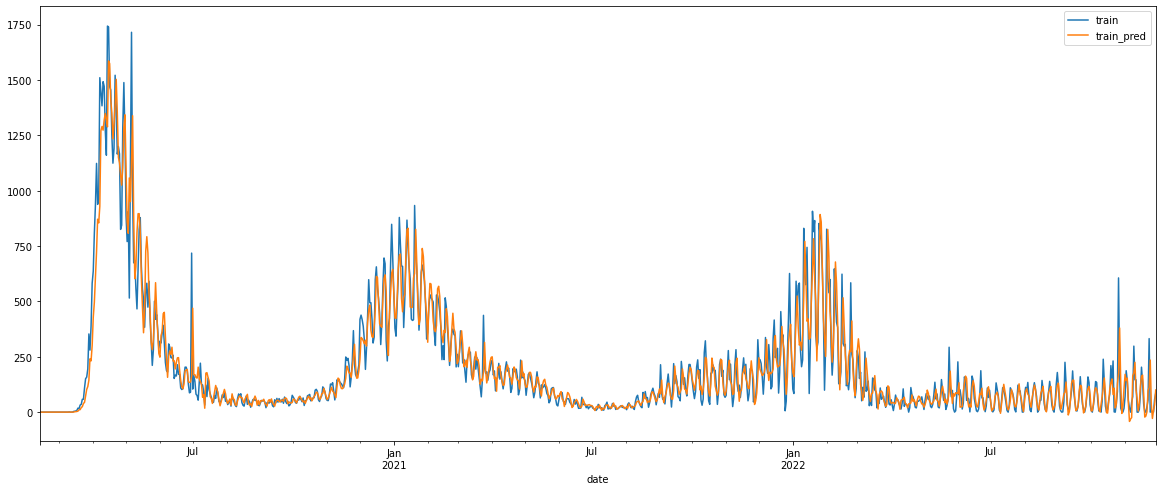

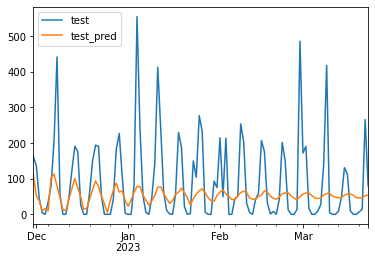

Training Set Metrics:
R-squared: 0.8995634465744584
MAE: 48.442066925165335
MASE: 0.00020378410448084874

Testing Set Metrics:
R-squared: 0.20492730757263966
MAE: 71.65543920582272
MASE: 0.007089722151207024


In [510]:
train_pred=model.fittedvalues()
pd.concat([east_train, train_pred], axis=1).plot(figsize=(20,8))
plt.legend(['train', 'train_pred'])
plt.show()

test_pred=model.predict(n_periods=len(east_test))
pd.concat([east_test, test_pred], axis=1).plot()
test_pred[test_pred<0] = 0

plt.legend(['test', 'test_pred'])
plt.show()

# Calculate R-squared, MAE for the training set
r2_train = r2_score(east_train, train_pred)
mae_train = mean_absolute_error(east_train, train_pred)
mase_train = MASE(east_train, train_pred)

print("Training Set Metrics:")
print("R-squared:", r2_train)
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate RMSE, R-squared, and MAE for the testing set
r2_test = r2_score(east_test, test_pred)
mae_test = mean_absolute_error(east_test, test_pred)
mase_test = MASE(east_test, test_pred)

print("\nTesting Set Metrics:")
print("R-squared:", r2_test)
print("MAE:", mae_test)
print("MASE:", mase_test)

# Old Models

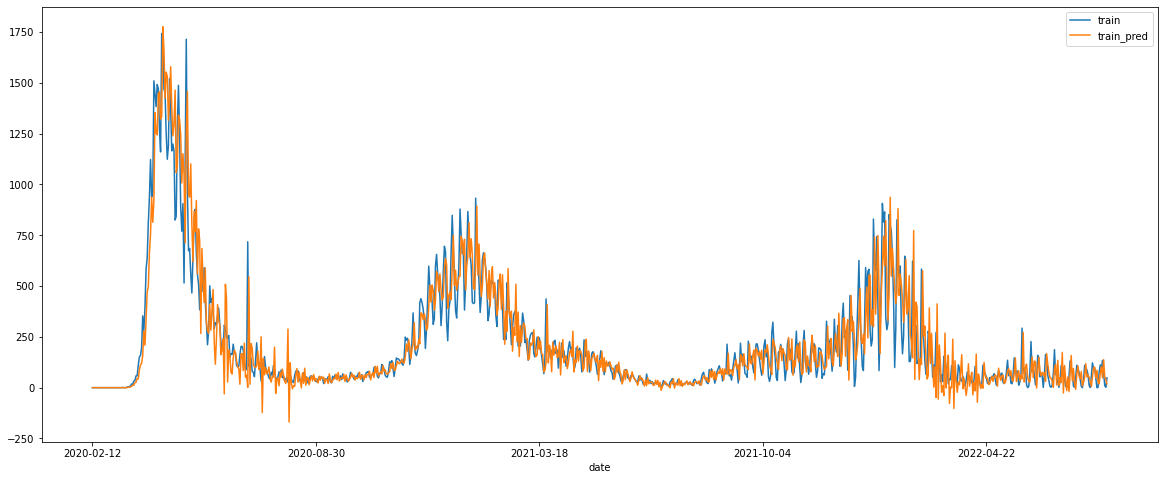

Training Set Metrics:
RMSE: 121.34734692046433
R-squared: 0.81103961739337

Testing Set Metrics:
RMSE: 107.8406647833716
R-squared: -0.11758821753885651


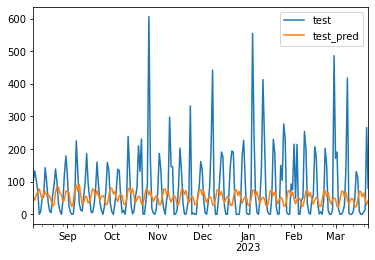

In [154]:
train_pred=model.fittedvalues()
pd.concat([east_train, train_pred], axis=1).plot(figsize=(20,8))
plt.legend(['train', 'train_pred'])
plt.show()

test_pred=model.predict(n_periods=len(east_test))
pd.concat([east_test, test_pred], axis=1).plot()

plt.legend(['test', 'test_pred'])

# Calculate RMSE, R-squared, and MAE for the training set
rmse_train = np.sqrt(mean_squared_error(east_train, train_pred))
r2_train = r2_score(east_train, train_pred)
mae_train = mean_absolute_error(east_train, train_pred)

print("Training Set Metrics:")
print("RMSE:", rmse_train)
print("R-squared:", r2_train)

# Calculate RMSE, R-squared, and MAE for the testing set
rmse_test = np.sqrt(mean_squared_error(east_test, test_pred))
r2_test = r2_score(east_test, test_pred)
mae_test = mean_absolute_error(east_test, test_pred)

print("\nTesting Set Metrics:")
print("RMSE:", rmse_test)
print("R-squared:", r2_test)

In [153]:
model = auto_arima(east_train, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=0, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(model.aic())

Performing stepwise search to minimize aic


/Users/alissachu/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.12 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=12190.358, Time=0.06 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=11479.077, Time=0.94 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=11662.080, Time=0.92 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=12188.369, Time=0.06 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=11667.296, Time=0.12 sec


/Users/alissachu/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=11296.823, Time=3.66 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=3.94 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=4.13 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=12162.075, Time=3.81 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=11297.545, Time=4.83 sec


/Users/alissachu/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=11295.176, Time=10.08 sec


/Users/alissachu/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=11449.321, Time=1.58 sec
 ARIMA(1,0,1)(2,1,1)[12] intercept   : AIC=inf, Time=7.89 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=4.30 sec


/Users/alissachu/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=11656.506, Time=2.61 sec


/Users/alissachu/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=11228.603, Time=8.65 sec


/Users/alissachu/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,0,1)(1,1,0)[12] intercept   : AIC=11449.153, Time=2.97 sec
 ARIMA(2,0,1)(2,1,1)[12] intercept   : AIC=inf, Time=7.78 sec
 ARIMA(2,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=3.94 sec


/Users/alissachu/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(3,0,1)(2,1,0)[12] intercept   : AIC=11192.629, Time=11.44 sec


/Users/alissachu/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(3,0,1)(1,1,0)[12] intercept   : AIC=11345.648, Time=5.76 sec
 ARIMA(3,0,1)(2,1,1)[12] intercept   : AIC=inf, Time=20.59 sec
 ARIMA(3,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=6.97 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept   : AIC=11251.552, Time=11.78 sec
 ARIMA(3,0,2)(2,1,0)[12] intercept   : AIC=inf, Time=14.68 sec
 ARIMA(2,0,2)(2,1,0)[12] intercept   : AIC=11206.786, Time=5.64 sec


/Users/alissachu/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(3,0,1)(2,1,0)[12]             : AIC=11190.629, Time=7.02 sec


/Users/alissachu/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(3,0,1)(1,1,0)[12]             : AIC=11330.226, Time=3.60 sec
 ARIMA(3,0,1)(2,1,1)[12]             : AIC=inf, Time=12.87 sec
 ARIMA(3,0,1)(1,1,1)[12]             : AIC=inf, Time=4.66 sec


/Users/alissachu/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,0,1)(2,1,0)[12]             : AIC=11226.605, Time=2.99 sec
 ARIMA(3,0,0)(2,1,0)[12]             : AIC=inf, Time=nan sec
 ARIMA(3,0,2)(2,1,0)[12]             : AIC=inf, Time=15.77 sec
 ARIMA(2,0,0)(2,1,0)[12]             : AIC=11295.547, Time=5.99 sec
 ARIMA(2,0,2)(2,1,0)[12]             : AIC=11204.783, Time=7.18 sec

Best model:  ARIMA(3,0,1)(2,1,0)[12]          
Total fit time: 222.946 seconds
11190.62855590596


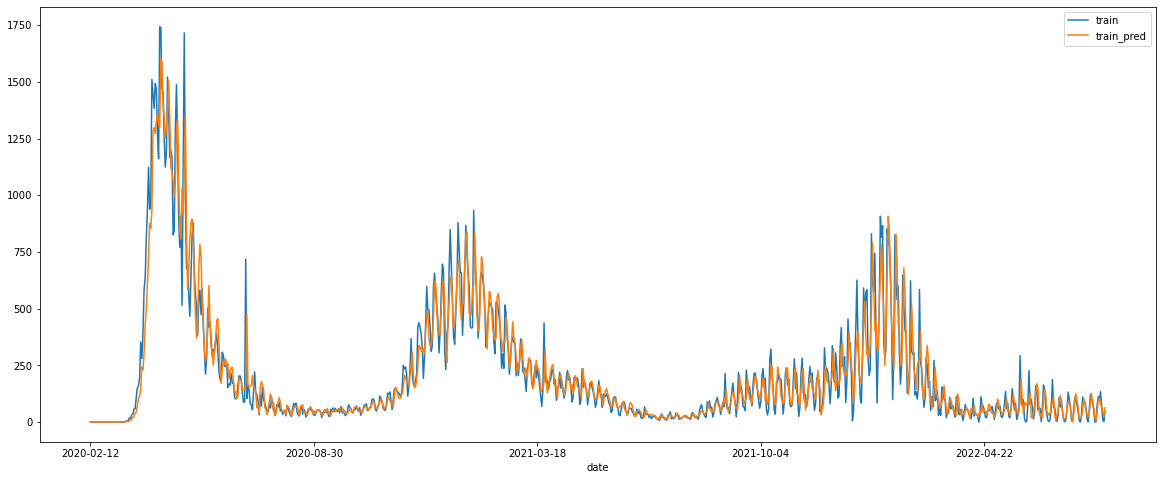

Training Set Metrics:
RMSE: 87.0713176427101
R-squared: 0.902711743206612

Testing Set Metrics:
RMSE: 108.39813386290325
R-squared: -0.12917255246763726


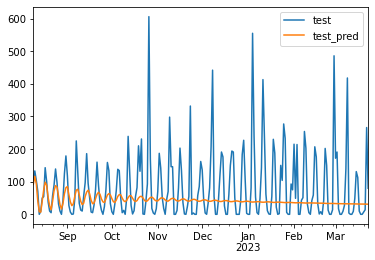

In [152]:
train_pred=model.fittedvalues()
pd.concat([east_train, train_pred], axis=1).plot(figsize=(20,8))
plt.legend(['train', 'train_pred'])
plt.show()

test_pred=model.predict(n_periods=len(east_test))
pd.concat([east_test, test_pred], axis=1).plot()

plt.legend(['test', 'test_pred'])

# Calculate RMSE, R-squared, and MAE for the training set
rmse_train = np.sqrt(mean_squared_error(east_train, train_pred))
r2_train = r2_score(east_train, train_pred)
mae_train = mean_absolute_error(east_train, train_pred)

print("Training Set Metrics:")
print("RMSE:", rmse_train)
print("R-squared:", r2_train)

# Calculate RMSE, R-squared, and MAE for the testing set
rmse_test = np.sqrt(mean_squared_error(east_test, test_pred))
r2_test = r2_score(east_test, test_pred)
mae_test = mean_absolute_error(east_test, test_pred)

print("\nTesting Set Metrics:")
print("RMSE:", rmse_test)
print("R-squared:", r2_test)

In [151]:
model = auto_arima(east_train, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=0, D=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(model.aic())

Performing stepwise search to minimize aic


/Users/alissachu/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=11125.377, Time=0.96 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=12822.181, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=11141.032, Time=0.79 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=11743.659, Time=0.86 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=13240.724, Time=0.02 sec


/Users/alissachu/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/alissachu/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=11161.521, Time=0.24 sec
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=11115.734, Time=1.58 sec


/Users/alissachu/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=11141.681, Time=1.09 sec
 ARIMA(1,0,1)(2,0,1)[12] intercept   : AIC=11067.358, Time=3.80 sec


/Users/alissachu/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,0,1)(2,0,0)[12] intercept   : AIC=11065.729, Time=4.28 sec


/Users/alissachu/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,0,1)(2,0,0)[12] intercept   : AIC=11661.325, Time=2.06 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=11107.453, Time=4.36 sec


/Users/alissachu/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,0,1)(2,0,0)[12] intercept   : AIC=11110.937, Time=4.48 sec
 ARIMA(1,0,2)(2,0,0)[12] intercept   : AIC=10983.262, Time=3.65 sec
 ARIMA(1,0,2)(1,0,0)[12] intercept   : AIC=11029.824, Time=1.28 sec
 ARIMA(1,0,2)(2,0,1)[12] intercept   : AIC=10985.168, Time=3.96 sec
 ARIMA(1,0,2)(1,0,1)[12] intercept   : AIC=11006.546, Time=2.74 sec
 ARIMA(0,0,2)(2,0,0)[12] intercept   : AIC=11509.503, Time=2.70 sec
 ARIMA(2,0,2)(2,0,0)[12] intercept   : AIC=10985.231, Time=5.66 sec


/Users/alissachu/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,0,3)(2,0,0)[12] intercept   : AIC=10985.189, Time=4.94 sec
 ARIMA(0,0,3)(2,0,0)[12] intercept   : AIC=11451.597, Time=4.07 sec
 ARIMA(2,0,3)(2,0,0)[12] intercept   : AIC=10847.140, Time=5.07 sec
 ARIMA(2,0,3)(1,0,0)[12] intercept   : AIC=10906.632, Time=2.36 sec
 ARIMA(2,0,3)(2,0,1)[12] intercept   : AIC=10873.165, Time=6.00 sec
 ARIMA(2,0,3)(1,0,1)[12] intercept   : AIC=inf, Time=2.75 sec
 ARIMA(3,0,3)(2,0,0)[12] intercept   : AIC=10744.105, Time=6.21 sec
 ARIMA(3,0,3)(1,0,0)[12] intercept   : AIC=10737.408, Time=2.88 sec
 ARIMA(3,0,3)(0,0,0)[12] intercept   : AIC=10738.551, Time=2.09 sec
 ARIMA(3,0,3)(1,0,1)[12] intercept   : AIC=10733.300, Time=3.36 sec
 ARIMA(3,0,3)(0,0,1)[12] intercept   : AIC=10730.447, Time=3.01 sec
 ARIMA(3,0,3)(0,0,2)[12] intercept   : AIC=10741.447, Time=6.84 sec
 ARIMA(3,0,3)(1,0,2)[12] intercept   : AIC=inf, Time=7.61 sec
 ARIMA(2,0,3)(0,0,1)[12] intercept   : AIC=10887.502, Time=2.33 sec
 ARIMA(3,0,2)(0,0,1)[12] intercept   : AIC=11091.446, Time=2

/Users/alissachu/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=11019.986, Time=1.54 sec
 ARIMA(3,0,3)(0,0,1)[12]             : AIC=10725.057, Time=1.46 sec
 ARIMA(3,0,3)(0,0,0)[12]             : AIC=10737.398, Time=0.90 sec
 ARIMA(3,0,3)(1,0,1)[12]             : AIC=10723.528, Time=2.45 sec
 ARIMA(3,0,3)(1,0,0)[12]             : AIC=10724.598, Time=1.45 sec
 ARIMA(3,0,3)(2,0,1)[12]             : AIC=10723.707, Time=5.50 sec
 ARIMA(3,0,3)(1,0,2)[12]             : AIC=inf, Time=6.56 sec
 ARIMA(3,0,3)(0,0,2)[12]             : AIC=10726.892, Time=3.99 sec
 ARIMA(3,0,3)(2,0,0)[12]             : AIC=10726.347, Time=3.00 sec
 ARIMA(3,0,3)(2,0,2)[12]             : AIC=10723.642, Time=8.46 sec
 ARIMA(2,0,3)(1,0,1)[12]             : AIC=10877.132, Time=2.02 sec
 ARIMA(3,0,2)(1,0,1)[12]             : AIC=11097.125, Time=2.83 sec
 ARIMA(2,0,2)(1,0,1)[12]             : AIC=11006.874, Time=1.76 sec

Best model:  ARIMA(3,0,3)(1,0,1)[12]          
Total fit time: 148.620 seconds
10723.527602739998


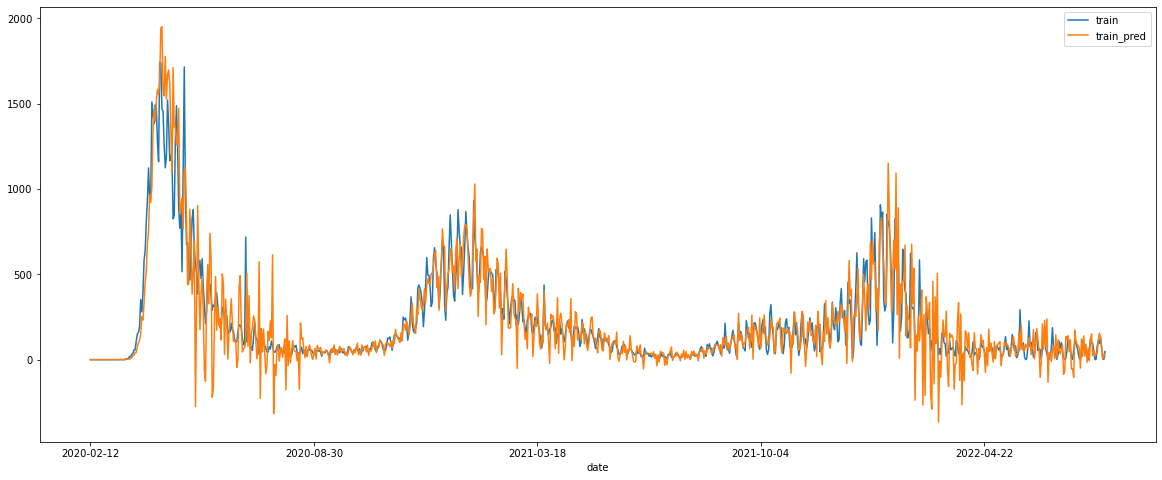

Training Set Metrics:
RMSE: 142.35526386018694
R-squared: 0.7399497654592128

Testing Set Metrics:
RMSE: 219.21966443749207
R-squared: -3.6182317098931565


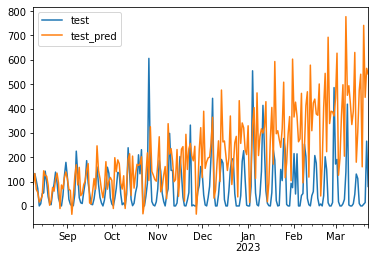

In [150]:
train_pred=model.fittedvalues()
pd.concat([east_train, train_pred], axis=1).plot(figsize=(20,8))
plt.legend(['train', 'train_pred'])
plt.show()

test_pred=model.predict(n_periods=len(east_test))
pd.concat([east_test, test_pred], axis=1).plot()

plt.legend(['test', 'test_pred'])

# Calculate RMSE, R-squared, and MAE for the training set
rmse_train = np.sqrt(mean_squared_error(east_train, train_pred))
r2_train = r2_score(east_train, train_pred)
mae_train = mean_absolute_error(east_train, train_pred)

print("Training Set Metrics:")
print("RMSE:", rmse_train)
print("R-squared:", r2_train)

# Calculate RMSE, R-squared, and MAE for the testing set
rmse_test = np.sqrt(mean_squared_error(east_test, test_pred))
r2_test = r2_score(east_test, test_pred)
mae_test = mean_absolute_error(east_test, test_pred)

print("\nTesting Set Metrics:")
print("RMSE:", rmse_test)
print("R-squared:", r2_test)

In [149]:
model = auto_arima(east_train, start_p=1, start_q=1,
                           max_p=5, max_q=5, m=12,
                           start_P=0, seasonal=True,
                           d=0, D=2, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(model.aic())

Performing stepwise search to minimize aic


/Users/alissachu/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,0,1)(0,2,1)[12]             : AIC=inf, Time=2.01 sec
 ARIMA(0,0,0)(0,2,0)[12]             : AIC=12669.629, Time=0.10 sec
 ARIMA(1,0,0)(1,2,0)[12]             : AIC=12044.444, Time=0.65 sec
 ARIMA(0,0,1)(0,2,1)[12]             : AIC=inf, Time=1.15 sec
 ARIMA(1,0,0)(0,2,0)[12]             : AIC=12405.752, Time=0.13 sec


/Users/alissachu/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,0,0)(2,2,0)[12]             : AIC=11770.062, Time=2.11 sec
 ARIMA(1,0,0)(2,2,1)[12]             : AIC=inf, Time=6.29 sec
 ARIMA(1,0,0)(1,2,1)[12]             : AIC=inf, Time=2.68 sec
 ARIMA(0,0,0)(2,2,0)[12]             : AIC=12321.464, Time=0.66 sec
 ARIMA(2,0,0)(2,2,0)[12]             : AIC=11757.178, Time=3.35 sec
 ARIMA(2,0,0)(1,2,0)[12]             : AIC=11964.110, Time=0.94 sec
 ARIMA(2,0,0)(2,2,1)[12]             : AIC=inf, Time=11.16 sec
 ARIMA(2,0,0)(1,2,1)[12]             : AIC=inf, Time=4.97 sec
 ARIMA(3,0,0)(2,2,0)[12]             : AIC=11741.168, Time=5.75 sec
 ARIMA(3,0,0)(1,2,0)[12]             : AIC=11961.126, Time=1.39 sec
 ARIMA(3,0,0)(2,2,1)[12]             : AIC=inf, Time=16.75 sec
 ARIMA(3,0,0)(1,2,1)[12]             : AIC=inf, Time=3.72 sec
 ARIMA(4,0,0)(2,2,0)[12]             : AIC=11735.361, Time=6.82 sec
 ARIMA(4,0,0)(1,2,0)[12]             : AIC=11961.086, Time=1.68 sec
 ARIMA(4,0,0)(2,2,1)[12]             : AIC=inf, Time=20.21 sec
 ARIMA(4,0,0)(1,2,1

/Users/alissachu/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(5,0,1)(2,2,0)[12]             : AIC=11544.398, Time=10.28 sec


/Users/alissachu/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(5,0,1)(1,2,0)[12]             : AIC=11755.110, Time=6.06 sec
 ARIMA(5,0,1)(2,2,1)[12]             : AIC=inf, Time=54.02 sec
 ARIMA(5,0,1)(1,2,1)[12]             : AIC=inf, Time=13.99 sec


/Users/alissachu/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(4,0,1)(2,2,0)[12]             : AIC=11630.766, Time=10.87 sec
 ARIMA(5,0,2)(2,2,0)[12]             : AIC=11356.864, Time=37.68 sec
 ARIMA(5,0,2)(1,2,0)[12]             : AIC=inf, Time=14.12 sec
 ARIMA(5,0,2)(2,2,1)[12]             : AIC=inf, Time=50.86 sec
 ARIMA(5,0,2)(1,2,1)[12]             : AIC=inf, Time=8.34 sec
 ARIMA(4,0,2)(2,2,0)[12]             : AIC=inf, Time=26.90 sec
 ARIMA(5,0,3)(2,2,0)[12]             : AIC=11698.912, Time=34.67 sec
 ARIMA(4,0,3)(2,2,0)[12]             : AIC=11728.036, Time=24.12 sec
 ARIMA(5,0,2)(2,2,0)[12] intercept   : AIC=11505.782, Time=35.17 sec

Best model:  ARIMA(5,0,2)(2,2,0)[12]          
Total fit time: 479.056 seconds
11356.86365150752


### auto ARIMA

/Users/alissachu/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/alissachu/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/alissachu/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


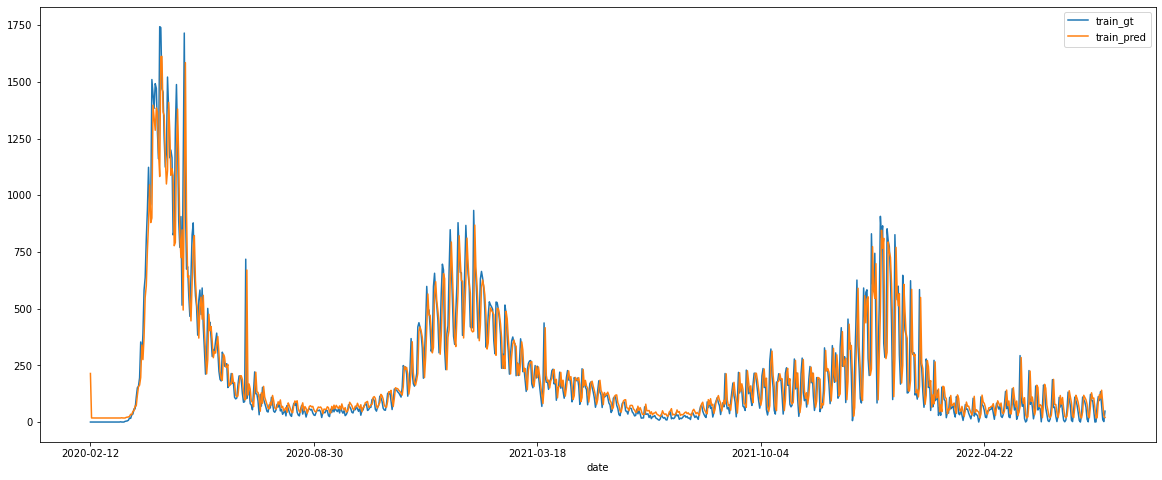

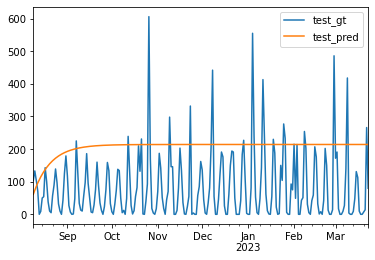

Training Set Metrics:
RMSE: 111.8150611123132
R-squared: 0.8395606848514352

Testing Set Metrics:
RMSE: 161.53370255049225
R-squared: -1.5075118677127683


In [147]:
model = ARIMA(east_train, order=(2, 0, 0))
model = model.fit()

train_pred=model.fittedvalues
pd.concat([east_train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])
plt.show()

east_test.index = pd.to_datetime(east_test.index)

test_pred=model.predict(start=len(east_train), end=len(east_train)+len(east_test)-1, dynamic=True)
pd.concat([east_test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])
plt.show()

# Calculate RMSE, R-squared, and MAE for the training set
rmse_train = np.sqrt(mean_squared_error(east_train, train_pred))
r2_train = r2_score(east_train, train_pred)
mae_train = mean_absolute_error(east_train, train_pred)

print("Training Set Metrics:")
print("RMSE:", rmse_train)
print("R-squared:", r2_train)

# Calculate RMSE, R-squared, and MAE for the testing set
rmse_test = np.sqrt(mean_squared_error(east_test, test_pred))
r2_test = r2_score(east_test, test_pred)
mae_test = mean_absolute_error(east_test, test_pred)

print("\nTesting Set Metrics:")
print("RMSE:", rmse_test)
print("R-squared:", r2_test)

### AR(2) Model

ACF tails off and PACF cutoff at lag 2 -> AR(2) model